In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ast
import itertools
import seaborn as sns
import glob
import os
import re

#### Transaction Delay - builder_review_time_per_tx / relay_review_time_per_tx

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_builder_review_time_per_tx_20250608_160608"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_review_time_per_tx_")]


def extract_builder_time(folder_name):
    match = re.search(r"builder_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_time)


for folder in folders:
    builder_time = extract_builder_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"brt_{builder_time:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   brt_0.000  Non-sanctioned (0)  17.516353   15.171453
1   brt_0.000      Sanctioned (1)  31.368704   66.353404
2   brt_0.001  Non-sanctioned (0)  17.063315   15.505118
3   brt_0.001      Sanctioned (1)  28.535329   55.331151
4   brt_0.002  Non-sanctioned (0)  17.070215   15.033902
5   brt_0.002      Sanctioned (1)  28.024542   56.759549
6   brt_0.003  Non-sanctioned (0)  18.275628   25.878

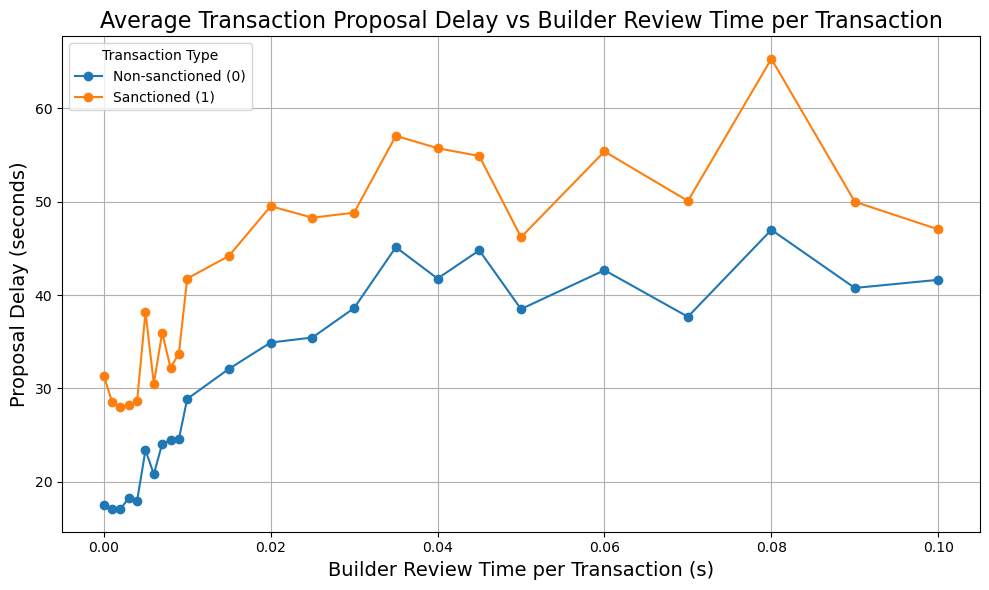

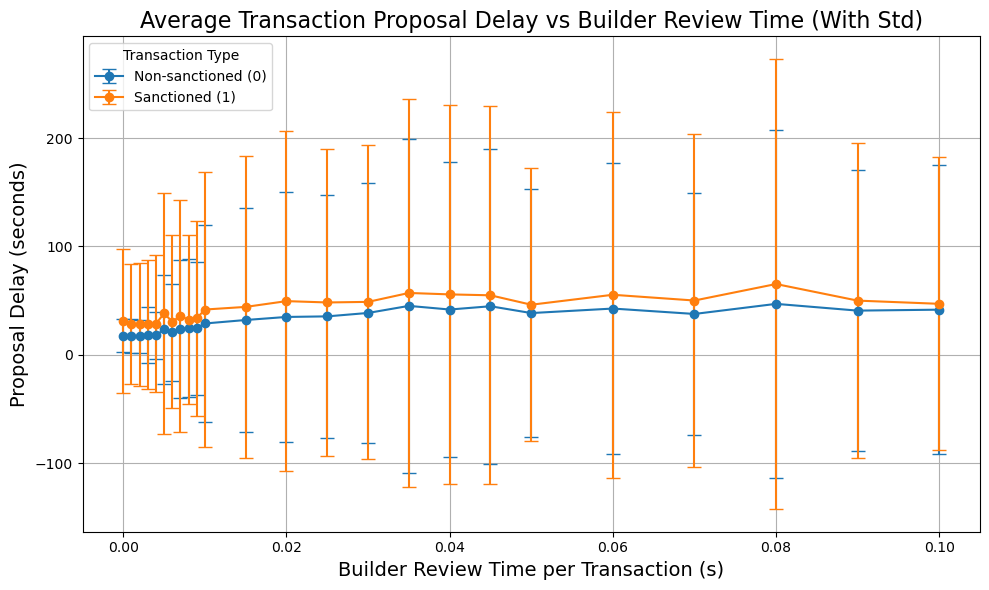

In [ ]:

final_stats['builder_review_time_per_tx'] = final_stats['experiment'].str.extract(r'brt_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['builder_review_time_per_tx'], group['mean'], '-o', label=label)

ax.set_xlabel('Builder Review Time per Transaction (s)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Review Time per Transaction', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['builder_review_time_per_tx'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Builder Review Time per Transaction (s)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Review Time (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


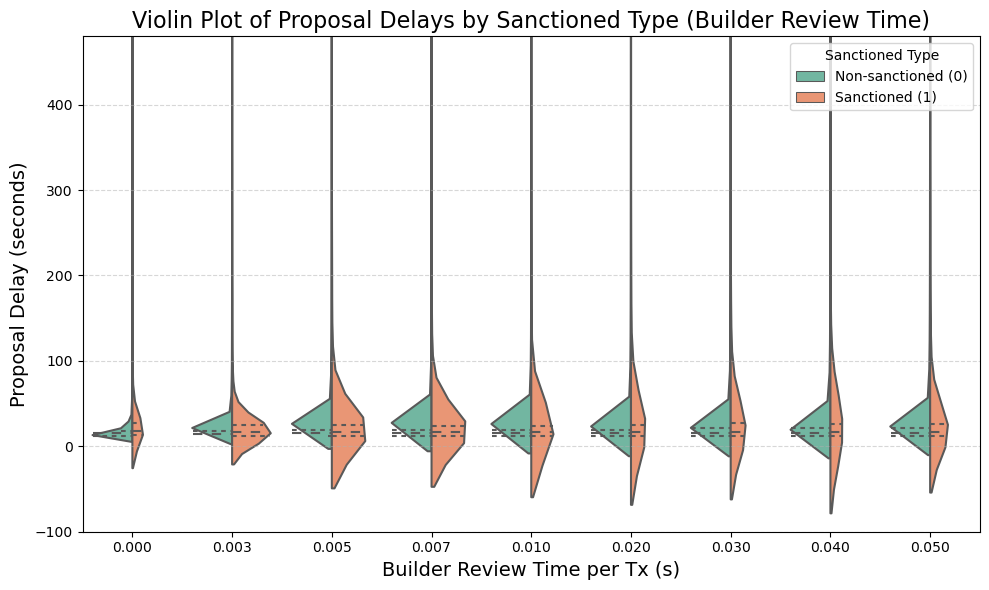

In [ ]:



selected_experiments = ['0.000', '0.003', '0.005', '0.007', '0.010', '0.020', '0.030', '0.040', '0.050', '0.10']

plt.figure(figsize=(10, 6))


builder_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('brt_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=builder_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.3f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Builder Review Time per Tx (s)', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Builder Review Time)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_review_time_per_tx_20250608_210512"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_review_time_per_tx_")]


def extract_relay_time(folder_name):
    match = re.search(r"relay_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_time)


for folder in folders:
    relay_time = extract_relay_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"rrt_{relay_time:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   rrt_0.000  Non-sanctioned (0)  15.887839   12.795670
1   rrt_0.000      Sanctioned (1)  21.489062   20.546859
2   rrt_0.001  Non-sanctioned (0)  15.887839   12.795670
3   rrt_0.001      Sanctioned (1)  21.489062   20.546859
4   rrt_0.002  Non-sanctioned (0)  15.887839   12.795670
5   rrt_0.002      Sanctioned (1)  21.489062   20.546859
6   rrt_0.003  Non-sanctioned (0)  15.887839   12.795

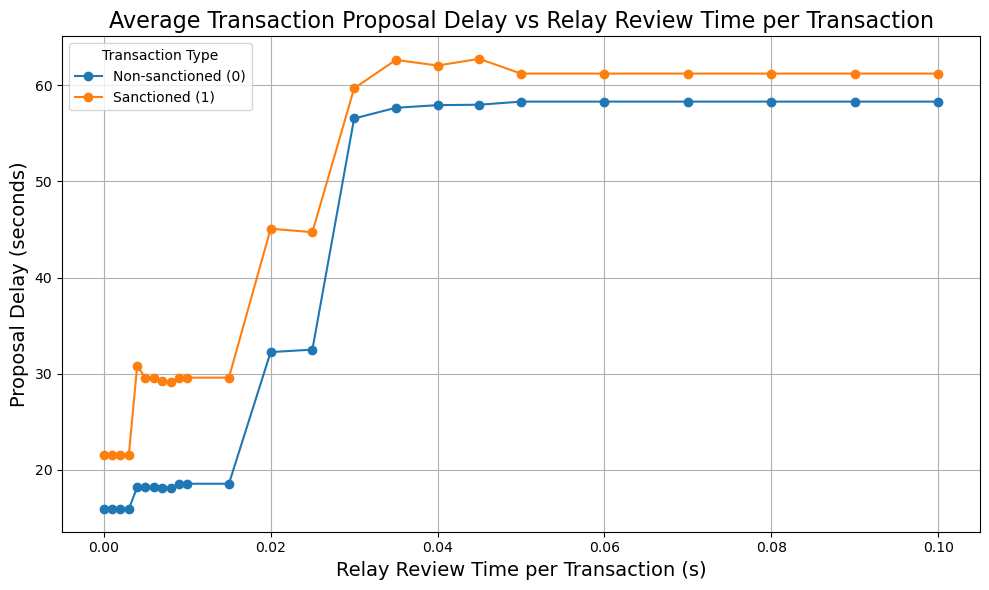

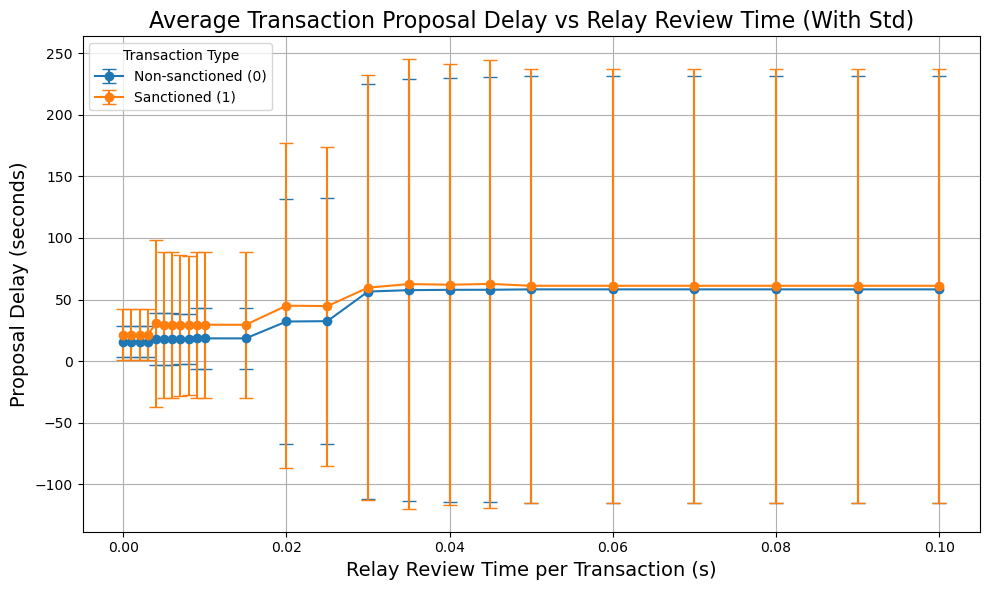

In [ ]:

final_stats['relay_review_time_per_tx'] = final_stats['experiment'].str.extract(r'rrt_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['relay_review_time_per_tx'], group['mean'], '-o', label=label)

ax.set_xlabel('Relay Review Time per Transaction (s)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Relay Review Time per Transaction', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['relay_review_time_per_tx'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Relay Review Time per Transaction (s)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Relay Review Time (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


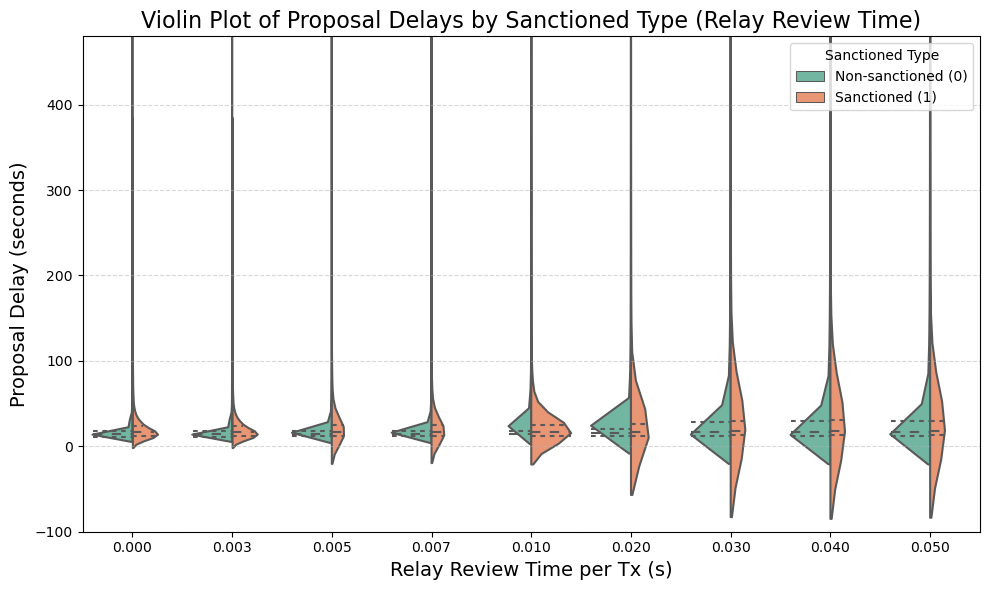

In [ ]:



selected_experiments =  ['0.000', '0.003', '0.005', '0.007', '0.010', '0.020', '0.030', '0.040', '0.050', '0.10']

plt.figure(figsize=(10, 6))


relay_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('rrt_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=relay_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.3f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Relay Review Time per Tx (s)', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Relay Review Time)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  builder_review_time_per_tx / relay_review_time_per_tx

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_builder_review_time_per_tx_20250608_160608"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_review_time_per_tx_")]


def extract_builder_time(folder_name):
    match = re.search(r"builder_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_time)


results = []

for folder in folders:
    builder_time = extract_builder_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

    
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

        
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

    
    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'brt_{builder_time:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: brt_{builder_time:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: brt_0.000
平均含 sanctioned_type=1 交易的区块数量: 133.900000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 165.900000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 44.66%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 55.34%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: brt_0.001
平均含 sanctioned_type=1 交易的区块数量: 134.700000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 165.200000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 44.92%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 55.08%
平均空区块数量: 0.100000
空区块占所有已提议区块的比例: 0.03%

Experiment: brt_0.002
平均含 sanctioned_type=1 交易的区块数量: 139.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 160.400000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.50%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.50%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: brt_0.003
平均含 sanctioned_type=1 交易的区块数量: 138.600000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 160.500000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.34%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.66%
平均空区块数量: 0.900000
空区块占所有已提议区块的比例: 0.30%


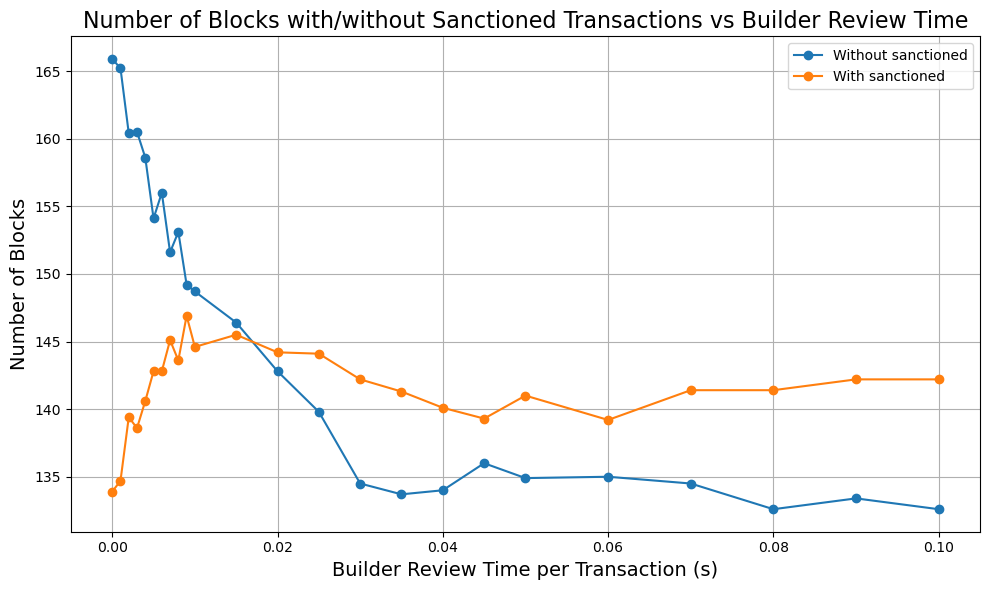

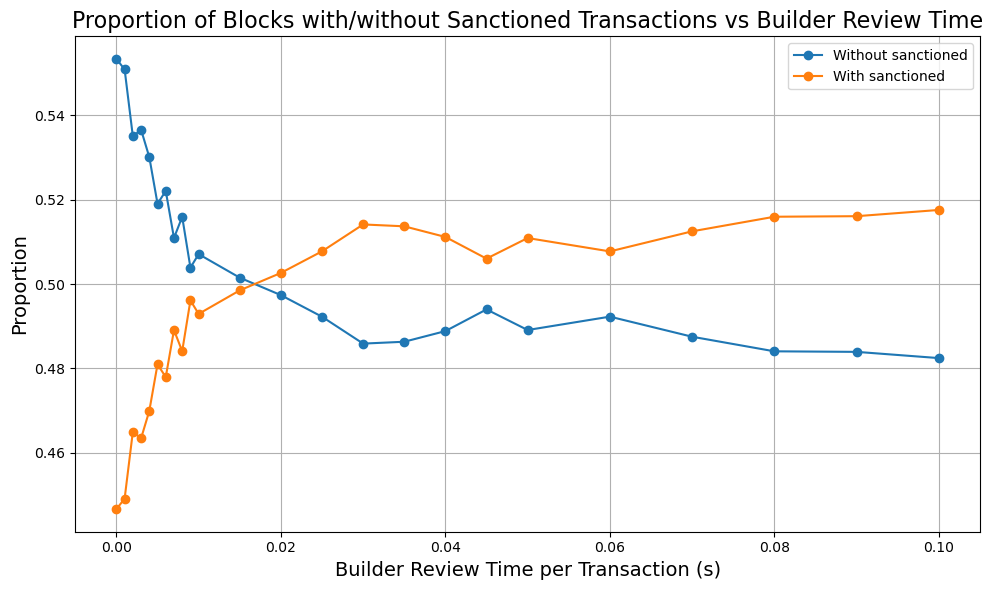

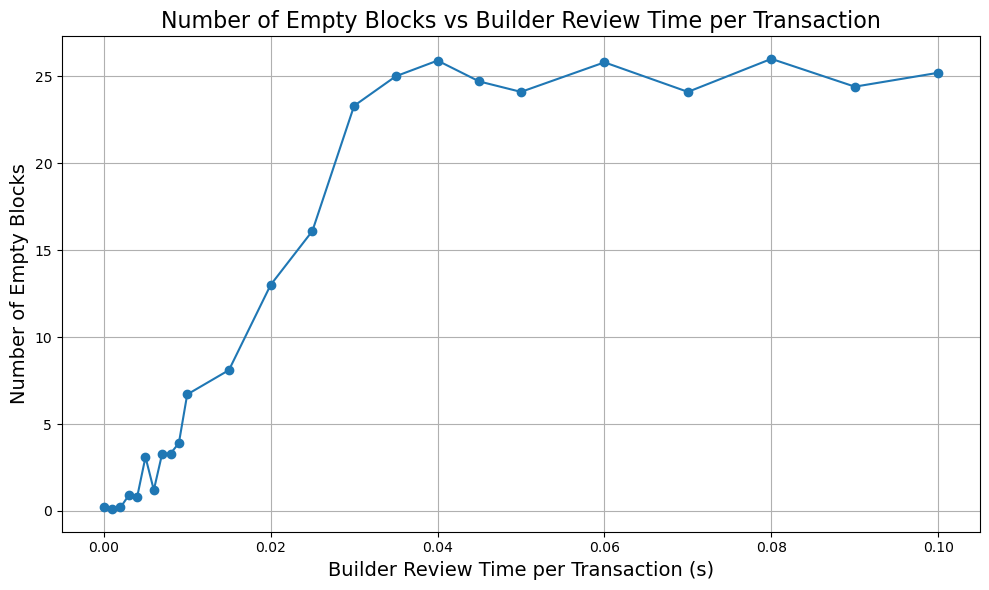

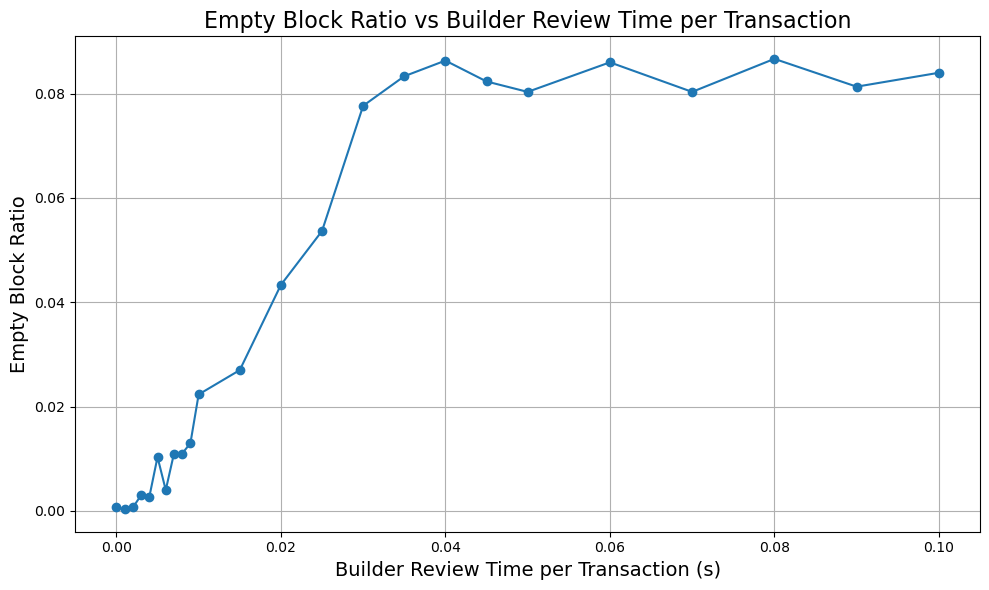

In [ ]:

results_df = pd.DataFrame(results)
results_df['builder_time'] = results_df['experiment'].str.extract(r'brt_(\d+\.\d+)').astype(float)

# Figure 1: Average number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_time'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_time'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Builder Review Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_time'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_time'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Builder Review Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_time'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Builder Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_time'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Builder Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_review_time_per_tx_20250608_210512"


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_review_time_per_tx_")]


def extract_relay_time(folder_name):
    match = re.search(r"relay_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_time)


results = []


for folder in folders:
    relay_time = extract_relay_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'rrt_{relay_time:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: rrt_{relay_time:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")




Experiment: rrt_0.000
平均含 sanctioned_type=1 交易的区块数量: 136.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 163.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 45.63%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 54.37%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: rrt_0.001
平均含 sanctioned_type=1 交易的区块数量: 136.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 163.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 45.63%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 54.37%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: rrt_0.002
平均含 sanctioned_type=1 交易的区块数量: 136.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 163.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 45.63%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 54.37%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: rrt_0.003
平均含 sanctioned_type=1 交易的区块数量: 136.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 163.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 45.63%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 54.37%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%


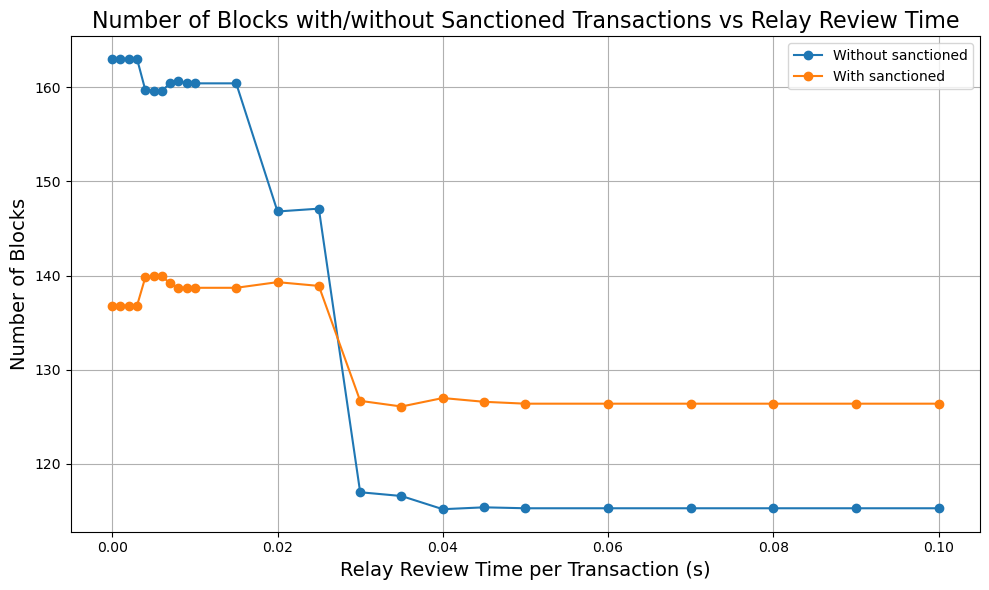

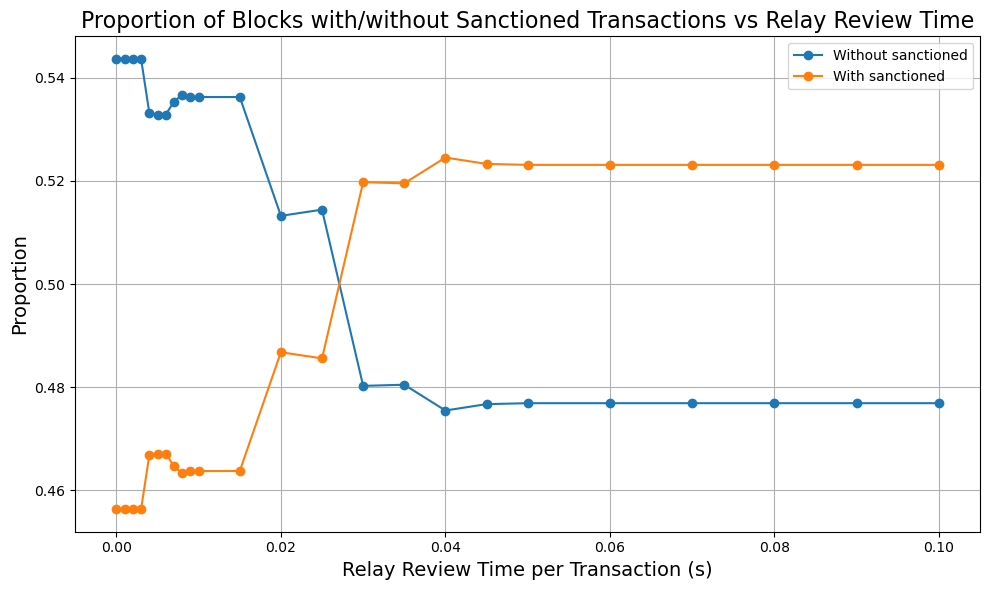

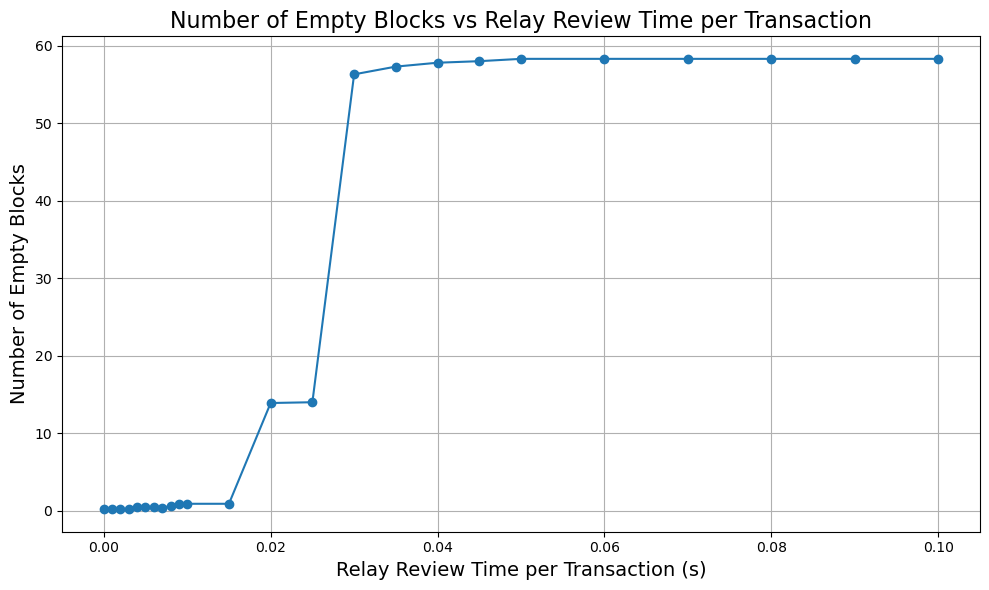

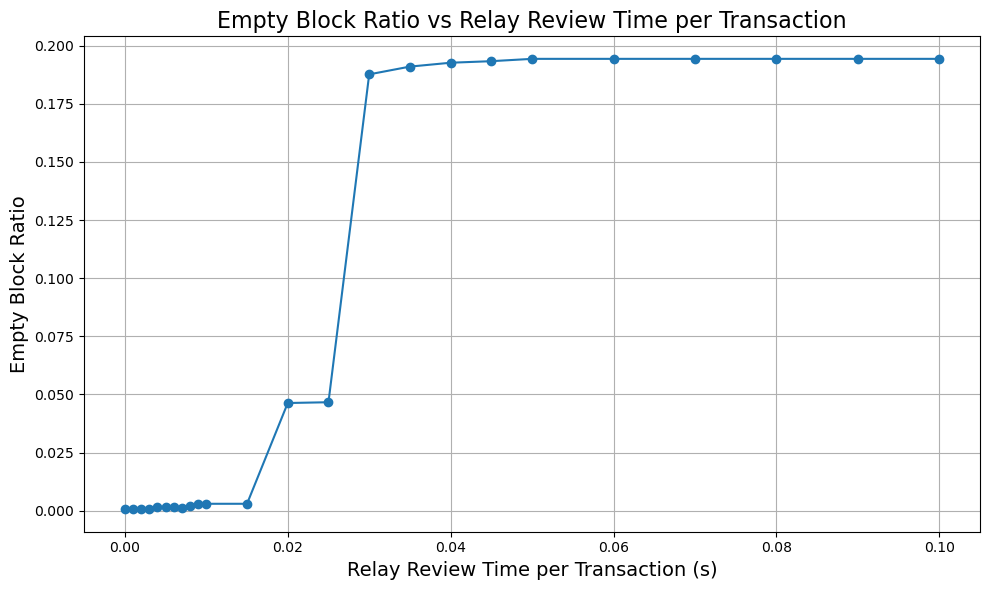

In [ ]:

results_df = pd.DataFrame(results)
results_df['relay_time'] = results_df['experiment'].str.extract(r'rrt_(\d+\.\d+)').astype(float)

# Figure 1: Average number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_time'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['relay_time'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Relay Review Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_time'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['relay_time'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Relay Review Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_time'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Relay Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_time'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Relay Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

#### total_block_value，mean_block_value  - builder_review_time_per_tx / relay_review_time_per_tx

In [ ]:

# Calculate total and mean block value statistics
def calculate_block_value_stats(exp_blocks, builder_time):
    
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

    
    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

    
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'builder_time': builder_time,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同builder_review_time参数下的总区块价值和平均区块价值:
    builder_time  avg_total_block_value  avg_mean_block_value  \
0          0.000           1.190766e+10          3.971888e+07   
1          0.001           1.190864e+10          3.970875e+07   
2          0.002           1.190856e+10          3.972188e+07   
3          0.003           1.190847e+10          3.981486e+07   
4          0.004           1.190801e+10          3.979999e+07   
5          0.005           1.190705e+10          4.010833e+07   
6          0.006           1.190777e+10          3.985313e+07   
7          0.007           1.190668e+10          4.013519e+07   
8          0.008           1.190518e+10          4.013230e+07   
9          0.009           1.190627e+10          4.021572e+07   
10         0.010           1.190125e+10          4.058386e+07   
11         0.015           1.189644e+10          4.076419e+07   
12         0.020           1.188291e+10          4.141707e+07   
13         0.025           1.186555e+10          4.

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


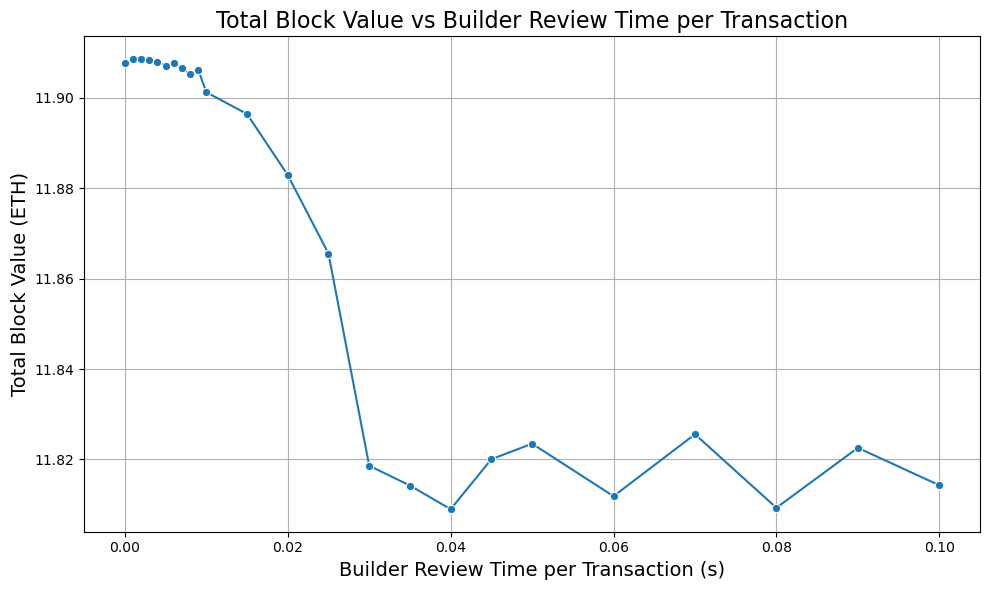

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


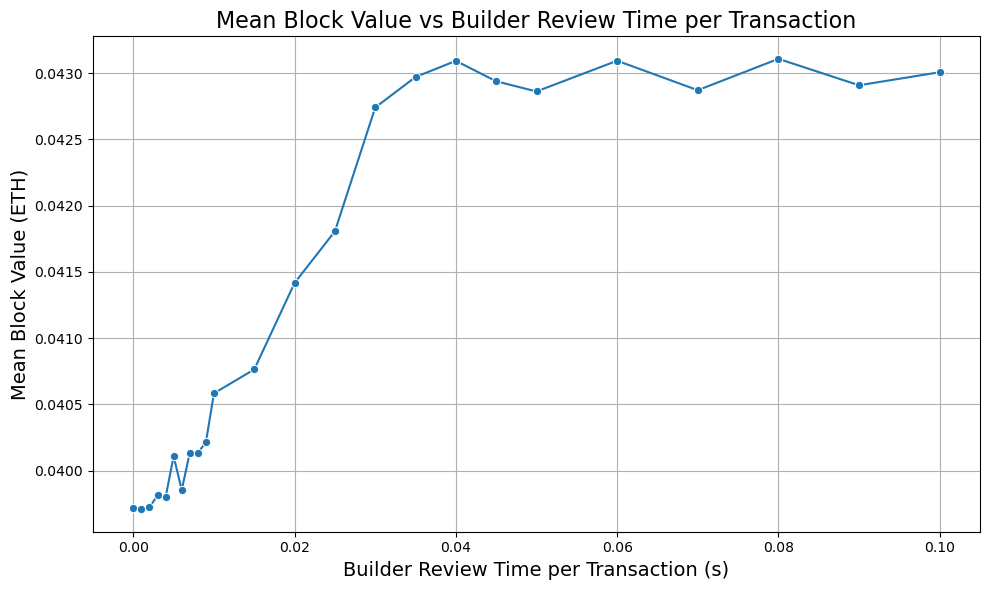

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_review_time_per_tx_20250608_160608"


def extract_builder_time(folder_name):
    match = re.search(r"builder_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_review_time_per_tx_")]
folders.sort(key=extract_builder_time)

results = []


for folder in folders:
    builder_time = extract_builder_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_block_value_stats(blocks, builder_time)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同builder_review_time参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('builder_time'))

# Figure 1: Total Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_time', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Builder Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_time', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Builder Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

def calculate_block_value_stats(exp_blocks, relay_time):
   
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

  
    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

   
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'relay_time': relay_time,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同relay_review_time参数下的总区块价值和平均区块价值:
    relay_time  avg_total_block_value  avg_mean_block_value  \
0        0.000           1.190887e+10          3.972291e+07   
1        0.001           1.190887e+10          3.972291e+07   
2        0.002           1.190887e+10          3.972291e+07   
3        0.003           1.190887e+10          3.972291e+07   
4        0.004           1.190839e+10          3.976136e+07   
5        0.005           1.190839e+10          3.976135e+07   
6        0.006           1.190839e+10          3.976135e+07   
7        0.007           1.190848e+10          3.974840e+07   
8        0.008           1.190821e+10          3.977397e+07   
9        0.009           1.190821e+10          3.981423e+07   
10       0.010           1.190821e+10          3.981423e+07   
11       0.015           1.190821e+10          3.981423e+07   
12       0.020           1.188233e+10          4.153686e+07   
13       0.025           1.188318e+10          4.155373e+07   
14       0.030    

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


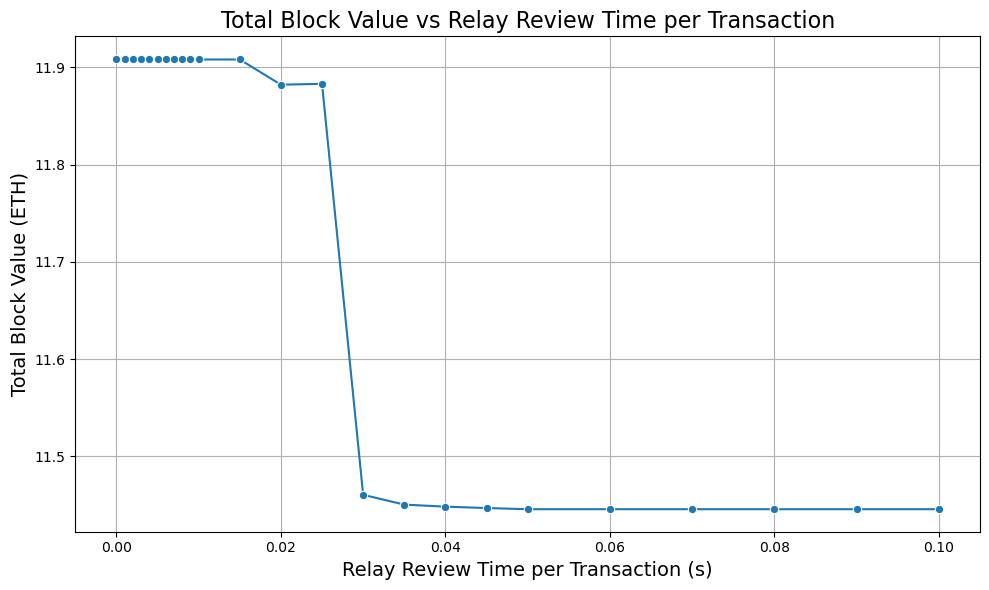

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


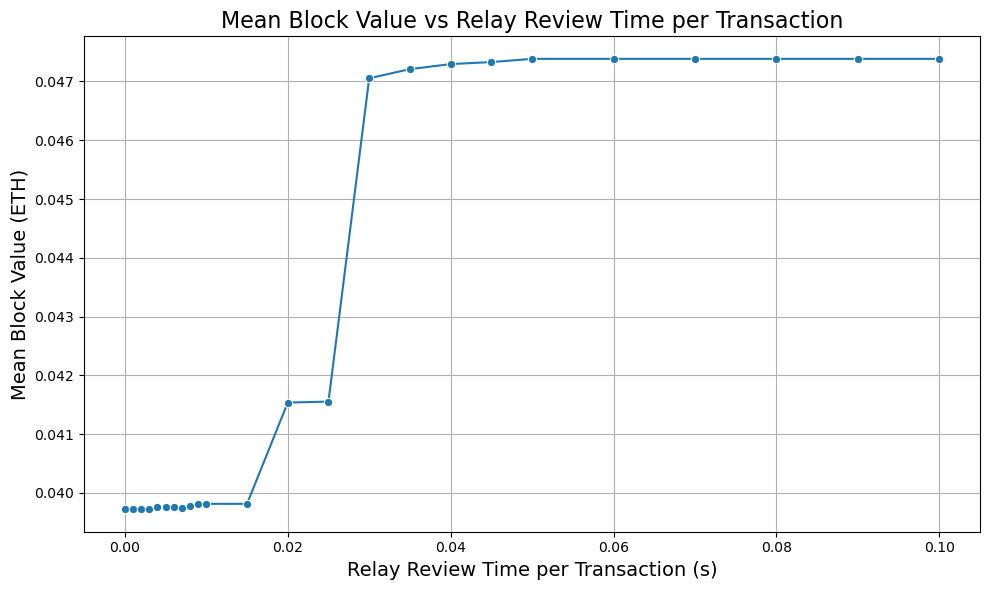

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_relay_review_time_per_tx_20250608_210512"


def extract_relay_time(folder_name):
    match = re.search(r"relay_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("relay_review_time_per_tx_")]
folders.sort(key=extract_relay_time)

results = []


for folder in folders:
    relay_time = extract_relay_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_block_value_stats(blocks, relay_time)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同relay_review_time参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('relay_time'))

# Figure 1: Total Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_time', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Relay Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_time', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Relay Review Time per Transaction', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types - builder_review_time_per_tx / relay_review_time_per_tx

In [ ]:
# Calculate builder profit by policy
def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
    
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

    
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

    
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.002055   
1         strict                            0.001818   
2           weak                            0.002000   
0            non                            0.002028   
1         strict                            0.001840   
2           weak                            0.002011   
0            non                            0.002036   
1         strict                            0.001810   
2           weak                            0.002009   
0            non                            0.002043   
1         strict                            0.001784   
2           weak                            0.002021   
0            non                            0.002047   
1         strict                            0.001745   
2           weak                            0.001947   
0            non                            0.002063   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

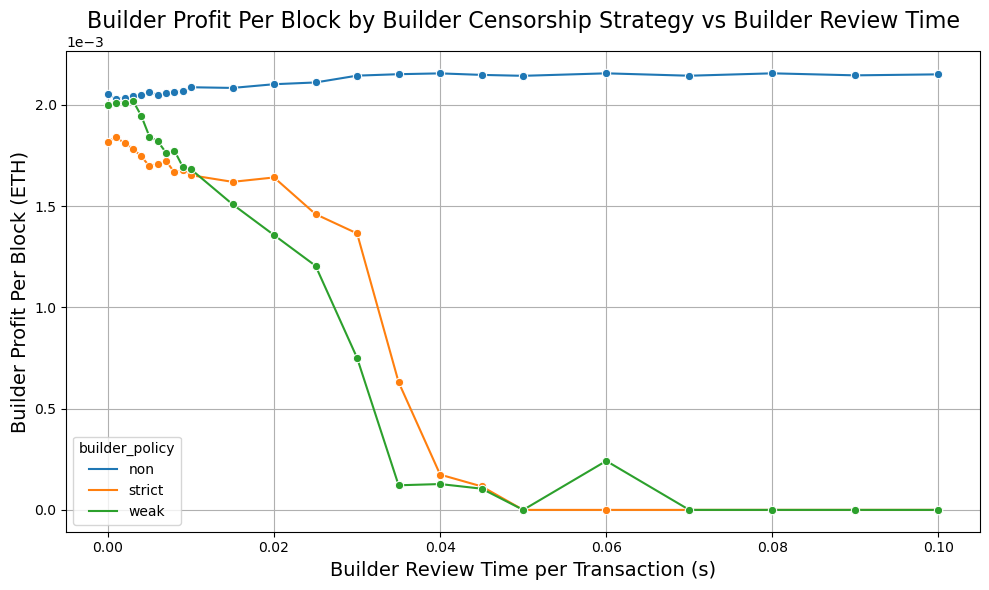

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

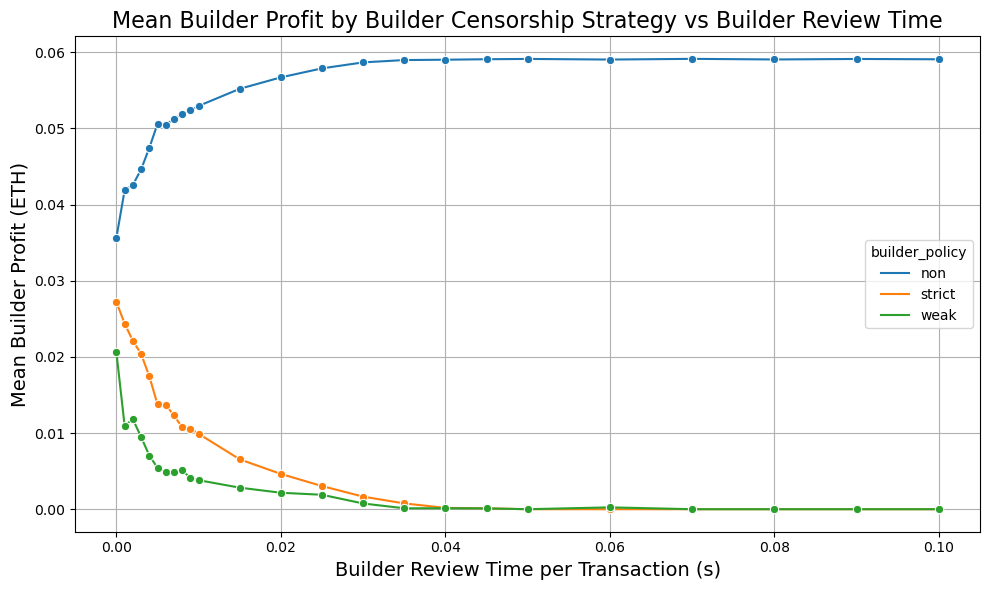

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_builder_review_time_per_tx_20250608_160608"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_review_time_per_tx_")]


def extract_builder_time(folder_name):
    match = re.search(r"builder_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_time)

results = []


for folder in folders:
    builder_time = extract_builder_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_builder_profit_by_policy(blocks, f'brt_{builder_time:.3f}')
    stats['builder_time'] = builder_time
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_time', 'builder_policy']))

# Figure 1: Builder Profit Per Block by Builder Censorship Strategy vs Builder Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_time', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Builder Review Time', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Builder Profit Per Builder by Builder Censorship Strategy vs Builder Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_time', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Builder Review Time', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.001998   
1         strict                            0.001918   
2           weak                            0.002014   
0            non                            0.001997   
1         strict                            0.001918   
2           weak                            0.002021   
0            non                            0.001998   
1         strict                            0.001918   
2           weak                            0.002014   
0            non                            0.001998   
1         strict                            0.001914   
2           weak                            0.002021   
0            non                            0.002058   
1         strict                            0.001732   
2           weak                            0.001999   
0            non                            0.002058   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

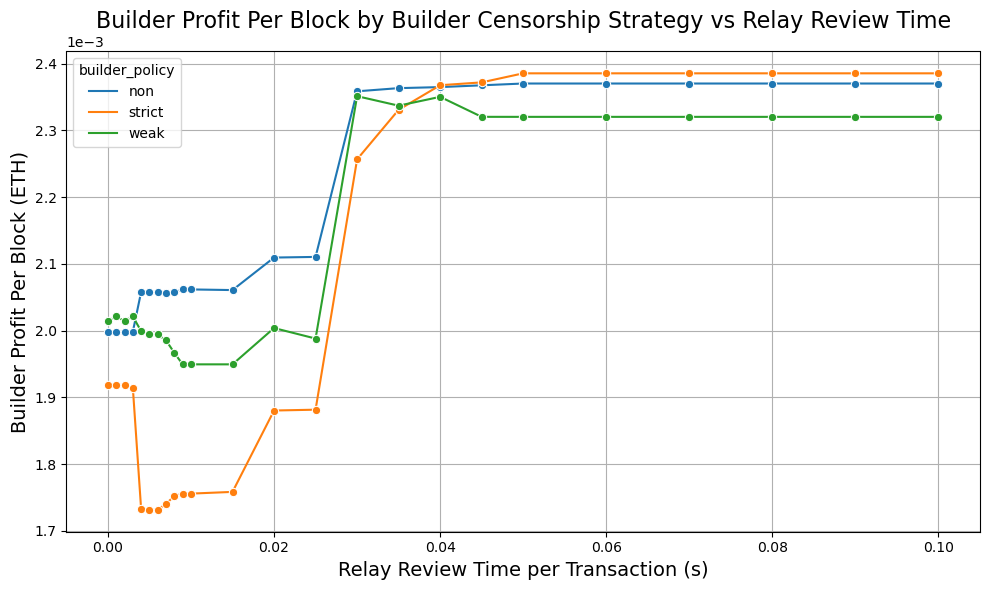

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

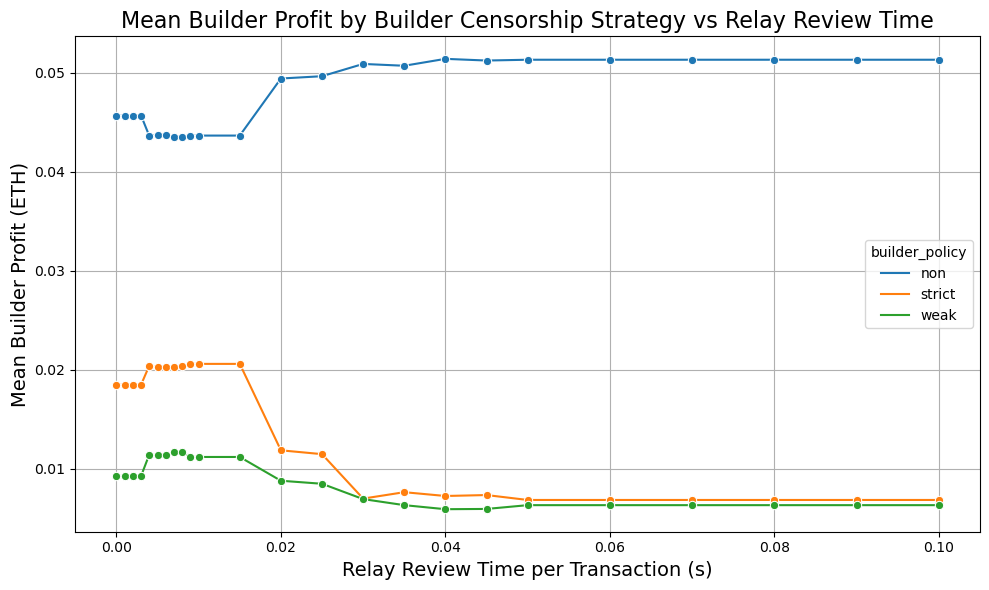

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_relay_review_time_per_tx_20250608_210512"


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_review_time_per_tx_")]


def extract_relay_time(folder_name):
    match = re.search(r"relay_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_time)

results = []


for folder in folders:
    relay_time = extract_relay_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_builder_profit_by_policy(blocks, f'rrt_{relay_time:.3f}')
    stats['relay_time'] = relay_time
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['relay_time', 'builder_policy']))

# Figure 1: Builder Profit Per Block by Builder Censorship Strategy vs Relay Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_time', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Relay Review Time', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Builder Profit Per Builder by Builder Censorship Strategy vs Relay Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_time', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Relay Review Time', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Average profit (per block & per node) for validators under different censorship types - builder_review_time_per_tx / relay_review_time_per_tx

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.039405   
1                             True                              0.030857   
0                            False                              0.039029   
1                             True                              0.032318   
0                            False                              0.039062   
1                             True                              0.032294   
0                            False                              0.039124   
1                             True                              0.032439   
0                            False                              0.039142   
1                             True                              0.032285   
0                            False                              0.039533   
1                             True                              0.031883   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

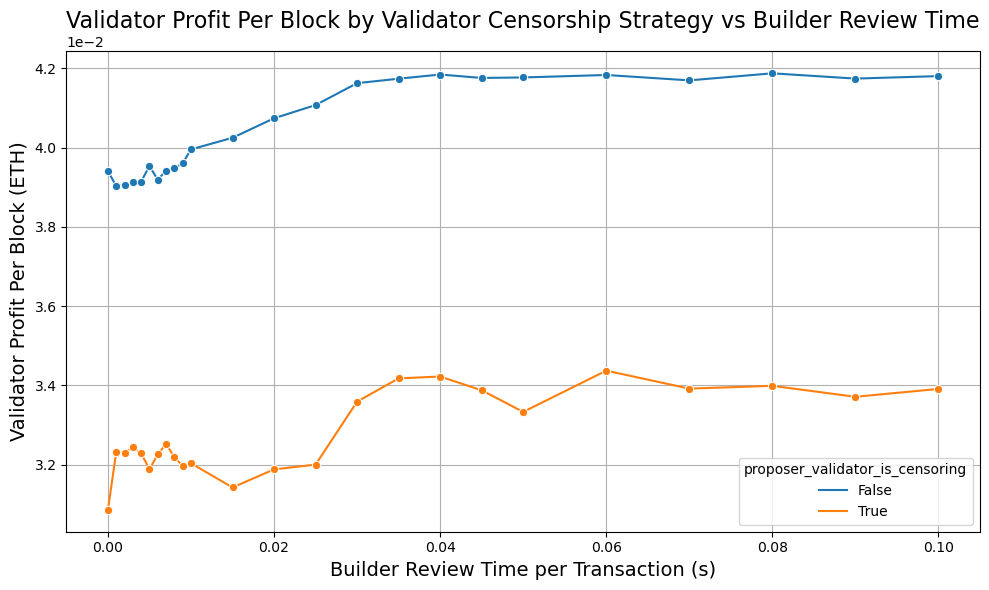

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

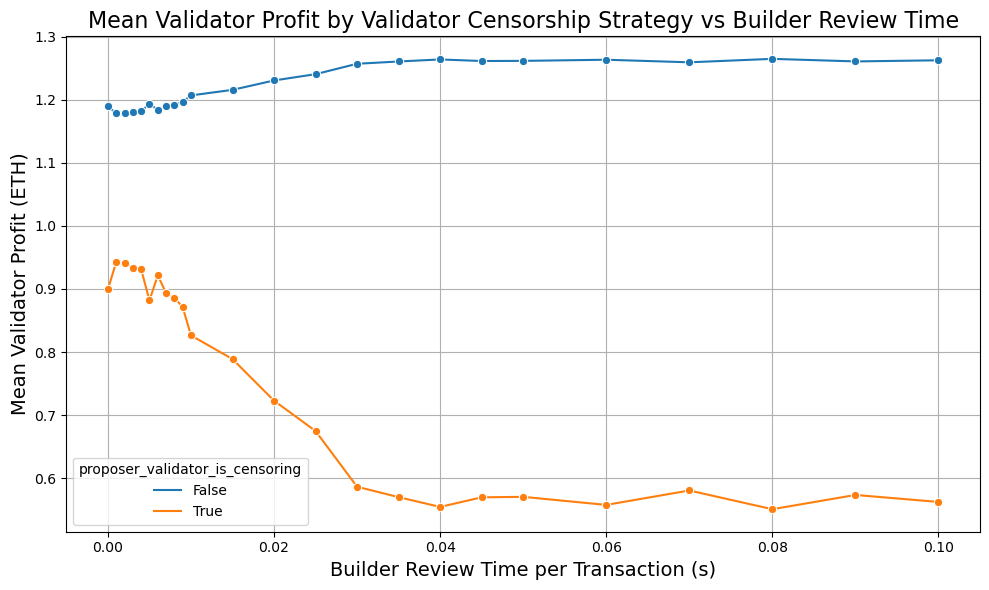

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_builder_review_time_per_tx_20250608_160608"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_review_time_per_tx_")]


def extract_builder_time(folder_name):
    match = re.search(r"builder_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_time)

results = []


for folder in folders:
    builder_time = extract_builder_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_validator_profit_by_policy(blocks, f'brt_{builder_time:.3f}')
    stats['builder_time'] = builder_time
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_time', 'proposer_validator_is_censoring']))

# Figure 1: Validator Profit Per Block by Validator Censorship Strategy vs Builder Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_time', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Builder Review Time', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Validator Profit Per Validator by Validator Censorship Strategy vs Builder Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_time', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Builder Review Time', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.038121   
1                             True                              0.036152   
0                            False                              0.038121   
1                             True                              0.036152   
0                            False                              0.038121   
1                             True                              0.036152   
0                            False                              0.038121   
1                             True                              0.036152   
0                            False                              0.039392   
1                             True                              0.031002   
0                            False                              0.039391   
1                             True                              0.031007   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

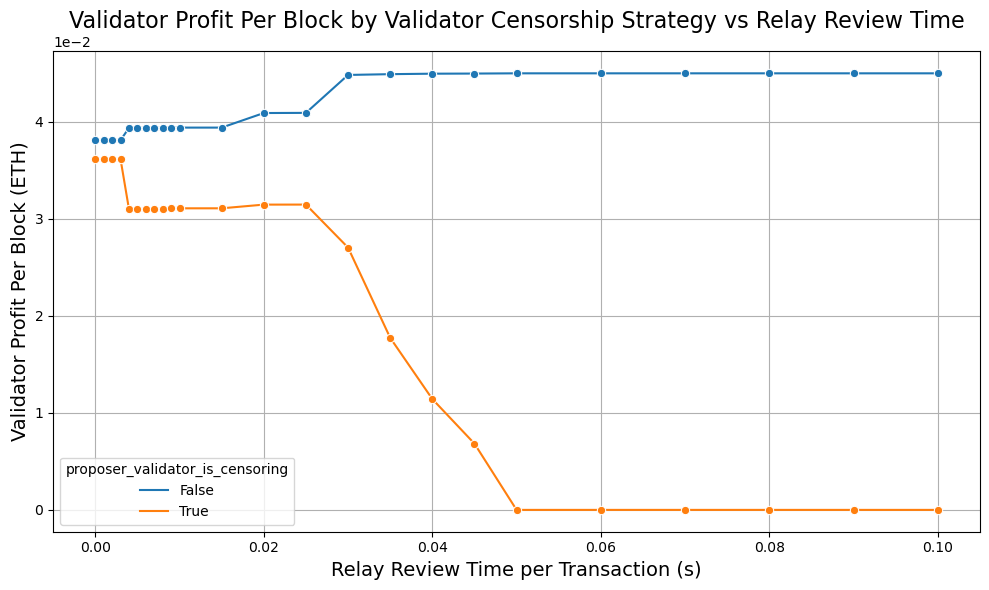

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

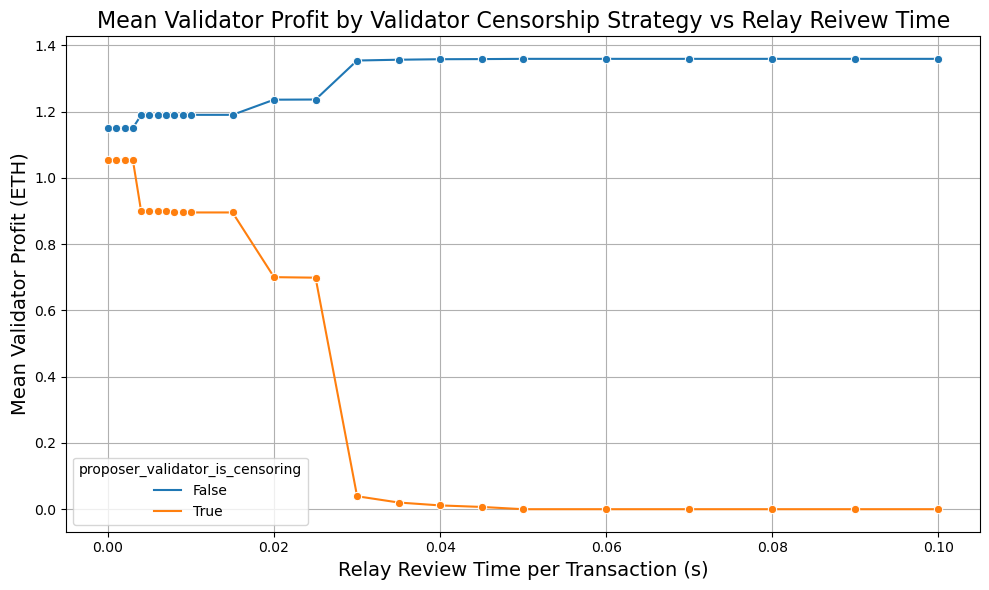

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_review_time_per_tx_20250608_210512"


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_review_time_per_tx_")]


def extract_relay_time(folder_name):
    match = re.search(r"relay_review_time_per_tx_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_time)

results = []


for folder in folders:
    relay_time = extract_relay_time(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_validator_profit_by_policy(blocks, f'rrt_{relay_time:.3f}')
    stats['relay_time'] = relay_time
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['relay_time', 'proposer_validator_is_censoring']))

# Figure 1: Validator Profit Per Block by Validator Censorship Strategy vs Relay Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_time', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Relay Review Time', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Validator Profit Per Validator by Validator Censorship Strategy vs Relay Review Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_time', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Relay Reivew Time', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Two factor analysis - builder_review_time_per_tx & relay_review_time_per_tx

#### Transaction Delay - builder_review_time_per_tx & relay_review_time_per_tx

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_review_time_per_tx_20250609_104129"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_review_time_per_tx_")]


def extract_builder_relay_times(folder_name):
    match = re.search(r"builder_relay_review_time_per_tx_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_time = float(match.group(1))
        relay_time = float(match.group(2))
        return (builder_time, relay_time)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_times)


for folder in folders:
    builder_time, relay_time = extract_builder_relay_times(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})


    transactions['experiment'] = f"brt_{builder_time:.3f}_rrt_{relay_time:.3f}"
    transactions['builder_time'] = builder_time
    transactions['relay_time'] = relay_time

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['builder_time', 'relay_time', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()

final_stats = run_stats.groupby(['builder_time', 'relay_time', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Builder & Relay Review Time per Tx and Sanctioned Type (averaged by run_id):")
# print(final_stats)

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  

display(final_stats)

Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment, builder_time, relay_time]
Index: []

[0 rows x 25 columns]

Proposal Delay Statistics by Builder & Relay Review Time per Tx and Sanctioned Type (averaged by run_id):


builder_time  relay_time     sanctioned_type       mean         std
0           0.000       0.000  Non-sanctioned (0)  15.517821   12.163806
1           0.000       0.000      Sanctioned (1)  22.470807   19.857703
2           0.000       0.003  Non-sanctioned (0)  15.517821   12.163806
3           0.000       0.003      Sanctioned (1)  22.470807   19.857703
4           0.000       0.005  Non-sanctioned (0)  17.940315   15.209368
5           0.000       0.005      Sanctioned (1)  36.142558   87.289805
6           0.000       0.007  Non-sanctioned (0)  17.940559   15.207668
7           0.000       0.007      Sanctioned (1)  35.372326   85.061720
8           0.000       0.010  Non-sanctioned (0)  17.966728   15.321726
9           0.000       0.010      Sanctioned (1)  35.348776   84.382234
10          0.000       0.020  Non-sanctioned (0)  17.966883   15.321966
11          0.000       0.020      Sanctioned (1)  35.348776   84.382234
12          0.000       0.030  Non-sanctioned (0)  56.908446  169.497580
13          0.000       0.030      Sanctioned (1)  63.557876  179.458902
14          0.000       0.040  Non-sanctioned (0)  57.723234  171.502558
15          0.000       0.040      Sanctioned (1)  66.156540  189.904795
16          0.000       0.050  Non-sanctioned (0)  58.042388  172.707525
17          0.000       0.050      Sanctioned (1)  64.957844  183.947392
18          0.003       0.000  Non-sanctioned (0)  16.018203   13.823860
19          0.003       0.000      Sanctioned (1)  22.667870   29.259779
20          0.003       0.003  Non-sanctioned (0)  16.018203   13.823860
21          0.003       0.003      Sanctioned (1)  22.667870   29.259779
22          0.003       0.005  Non-sanctioned (0)  18.688648   24.970438
23          0.003       0.005      Sanctioned (1)  32.022345   76.387824
24          0.003       0.007  Non-sanctioned (0)  18.755137   25.329613
25          0.003       0.007      Sanctioned (1)  31.720950   75.971835
26          0.003       0.010  Non-sanctioned (0)  18.840471   25.702115
27          0.003       0.010      Sanctioned (1)  31.907070   76.886255
28          0.003       0.020  Non-sanctioned (0)  35.623285  117.256933
29          0.003       0.020      Sanctioned (1)  46.682973  144.143849
30          0.003       0.030  Non-sanctioned (0)  54.903929  159.276519
31          0.003       0.030      Sanctioned (1)  58.703885  164.952852
32          0.003       0.040  Non-sanctioned (0)  56.648662  166.970341
33          0.003       0.040      Sanctioned (1)  60.816096  181.130162
34          0.003       0.050  Non-sanctioned (0)  58.241169  173.633446
35          0.003       0.050      Sanctioned (1)  64.928063  190.725504
36          0.005       0.000  Non-sanctioned (0)  16.018402   12.938075
37          0.005       0.000      Sanctioned (1)  21.130534   24.474152
38          0.005       0.003  Non-sanctioned (0)  16.018402   12.938075
39          0.005       0.003      Sanctioned (1)  21.130534   24.474152
40          0.005       0.005  Non-sanctioned (0)  30.856145  101.662238
41          0.005       0.005      Sanctioned (1)  45.487927  139.425409
42          0.005       0.007  Non-sanctioned (0)  31.381627  104.118712
43          0.005       0.007      Sanctioned (1)  44.986806  138.714854
44          0.005       0.010  Non-sanctioned (0)  29.793920   92.890002
45          0.005       0.010      Sanctioned (1)  43.176581  126.482677
46          0.005       0.020  Non-sanctioned (0)  36.918060  124.839324
47          0.005       0.020      Sanctioned (1)  47.694606  140.067883
48          0.005       0.030  Non-sanctioned (0)  57.276691  170.658311
49          0.005       0.030      Sanctioned (1)  62.520609  185.271316
50          0.005       0.040  Non-sanctioned (0)  58.259285  173.588049
51          0.005       0.040      Sanctioned (1)  62.234442  183.003654
52          0.005       0.050  Non-sanctioned (0)  58.404861  173.870971
53          0.005       0.050      Sanctioned (1)  62.430009  1

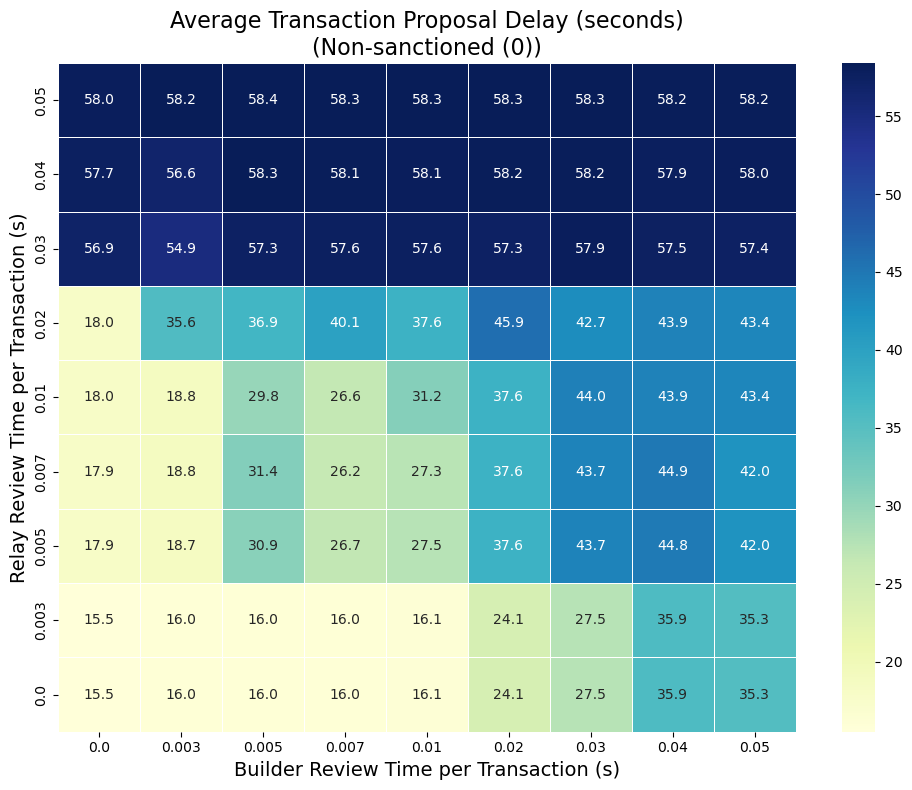

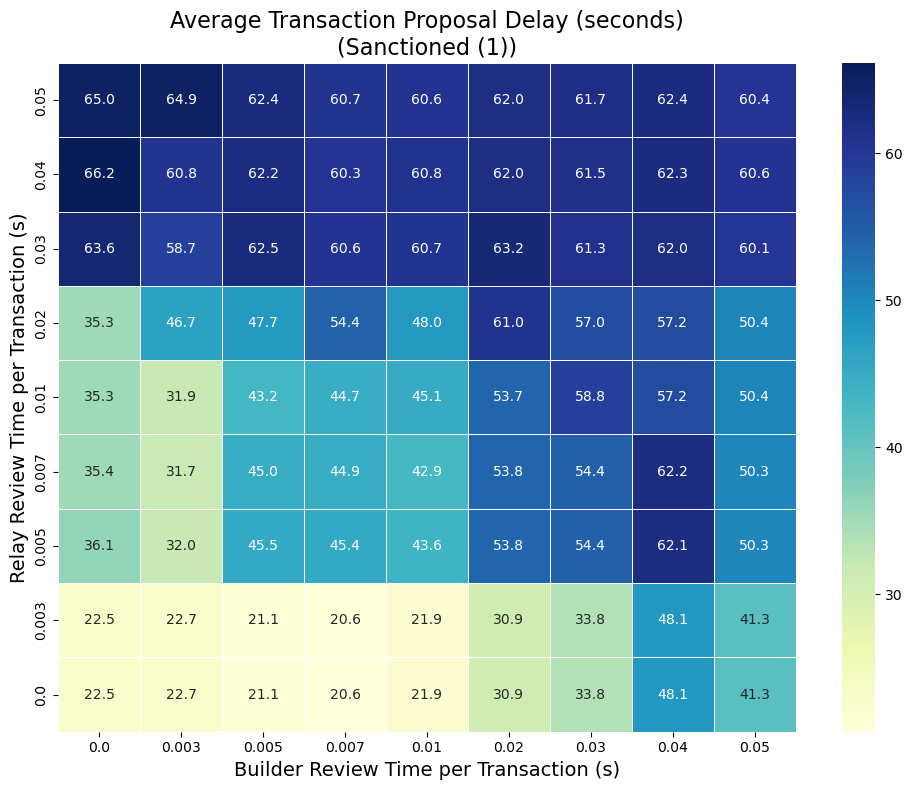

In [ ]:
for sanctioned_type in final_stats['sanctioned_type'].unique():
    subset = final_stats[final_stats['sanctioned_type'] == sanctioned_type]

    heatmap_data = subset.pivot(index='relay_time', columns='builder_time', values='mean')

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=.5,
        # cbar_kws={'label': 'Mean Proposal Delay (s)'}
    )

    # revsert the y-axis
    ax.invert_yaxis()

    plt.title(f'Average Transaction Proposal Delay (seconds)\n({sanctioned_type})', fontsize=16)
    plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
    plt.ylabel('Relay Review Time per Transaction (s)', fontsize=14)
    
    plt.tight_layout()
    plt.show()


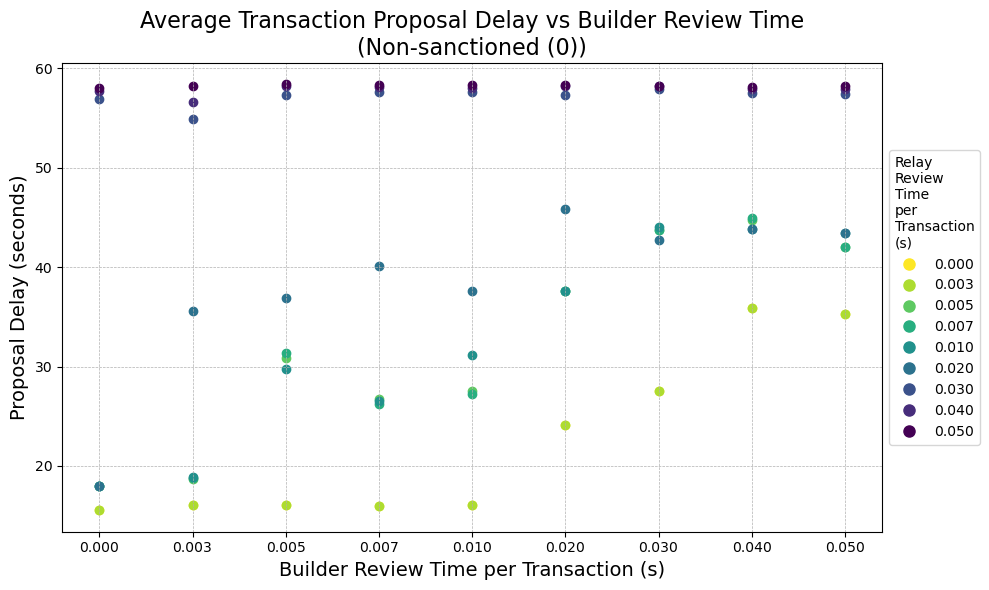

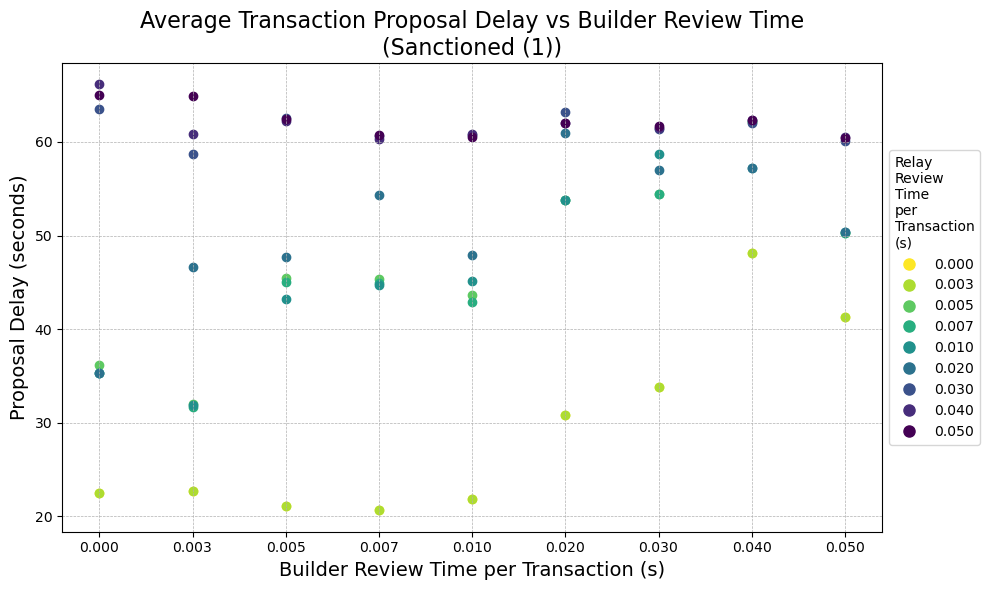

In [ ]:


relay_time_values = sorted(final_stats['relay_time'].unique())
colors = plt.cm.viridis(np.linspace(1, 0, len(relay_time_values)))  

for sanctioned_type in final_stats['sanctioned_type'].unique():
    subset = final_stats[final_stats['sanctioned_type'] == sanctioned_type]

    fig, ax = plt.subplots(figsize=(10, 6))

    
    unique_builder_times = sorted(subset['builder_time'].unique())
    builder_time_to_pos = {time: pos for pos, time in enumerate(unique_builder_times)}

    
    for i, relay_time in enumerate(relay_time_values):
        data = subset[subset['relay_time'] == relay_time]
        positions = [builder_time_to_pos[bt] for bt in data['builder_time']]
        ax.scatter(positions, data['mean'],
                   color=colors[i], marker='o', label=f'{relay_time:.3f}', alpha=1.0)

    ax.set_xlabel('Builder Review Time per Transaction (s)', fontsize=14)
    ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5)

    
    ax.set_xticks(range(len(unique_builder_times)))
    ax.set_xticklabels([f'{x:.3f}' for x in unique_builder_times])

   
    legend_elements = [plt.Line2D([0], [0], marker='o', color=colors[i], linestyle='', markersize=8, label=f'{relay_time:.3f}')
                       for i, relay_time in enumerate(relay_time_values)]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='Relay\nReview\nTime\nper\nTransaction\n(s)')

    plt.title(f'Average Transaction Proposal Delay vs Builder Review Time\n({sanctioned_type})', fontsize=16)
    plt.tight_layout()
    plt.show()

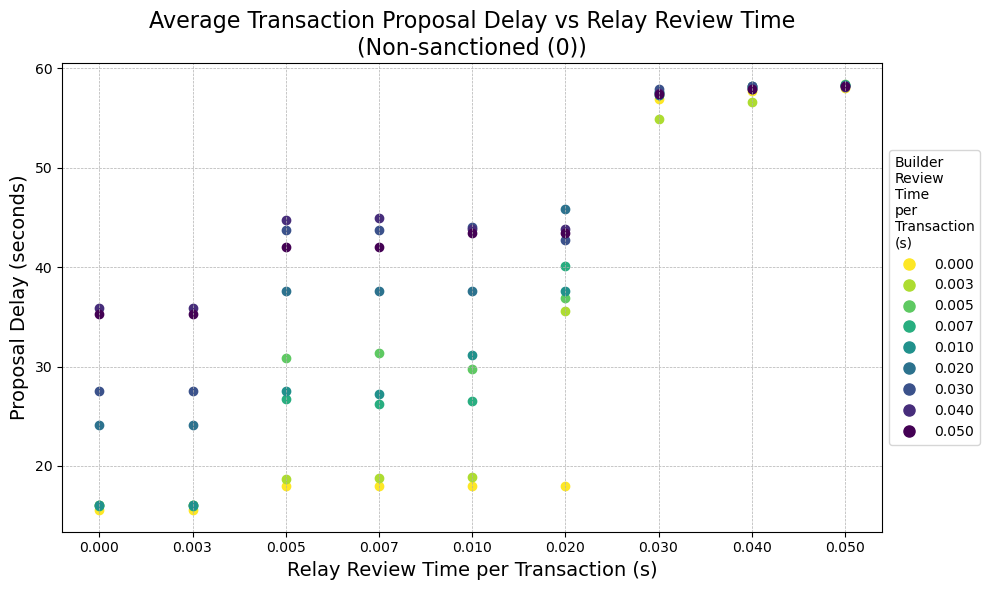

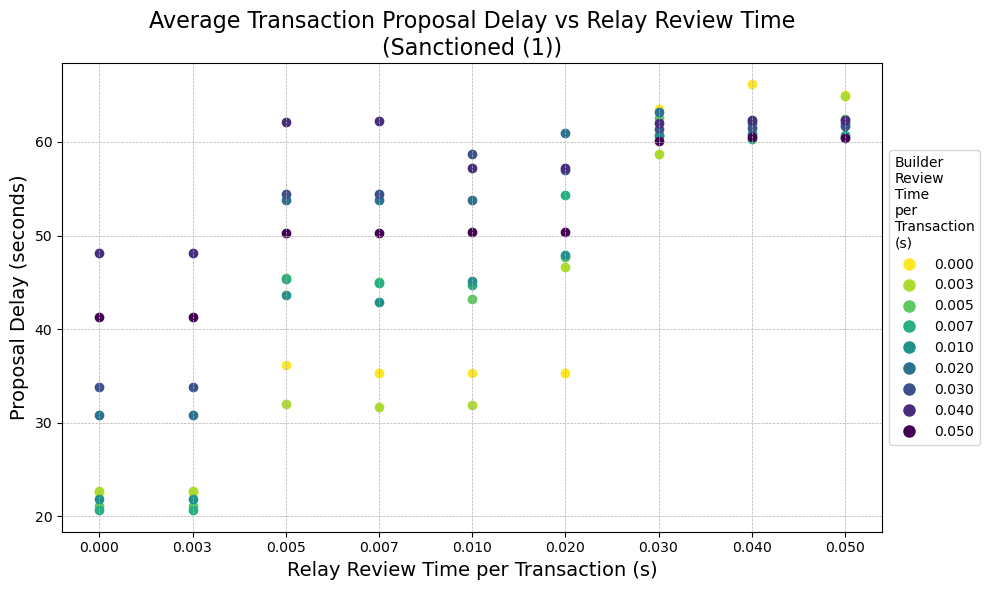

In [ ]:


builder_time_values = sorted(final_stats['builder_time'].unique())
colors = plt.cm.viridis(np.linspace(1, 0, len(builder_time_values))) 

for sanctioned_type in final_stats['sanctioned_type'].unique():
    subset = final_stats[final_stats['sanctioned_type'] == sanctioned_type]

    fig, ax = plt.subplots(figsize=(10, 6))

    
    unique_relay_times = sorted(subset['relay_time'].unique())
    relay_time_to_pos = {time: pos for pos, time in enumerate(unique_relay_times)}

    
    for i, builder_time in enumerate(builder_time_values):
        data = subset[subset['builder_time'] == builder_time]
        positions = [relay_time_to_pos[rt] for rt in data['relay_time']]
        ax.scatter(positions, data['mean'],
                   color=colors[i], marker='o', label=f'{builder_time:.3f}', alpha=1.0)

    ax.set_xlabel('Relay Review Time per Transaction (s)', fontsize=14)
    ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5)

    
    ax.set_xticks(range(len(unique_relay_times)))
    ax.set_xticklabels([f'{x:.3f}' for x in unique_relay_times])

    
    legend_elements = [plt.Line2D([0], [0], marker='o', color=colors[i], linestyle='', markersize=8, label=f'{builder_time:.3f}')
                       for i, builder_time in enumerate(builder_time_values)]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='Builder\nReview\nTime\nper\nTransaction\n(s)')

    plt.title(f'Average Transaction Proposal Delay vs Relay Review Time\n({sanctioned_type})', fontsize=16)
    plt.tight_layout()
    plt.show()


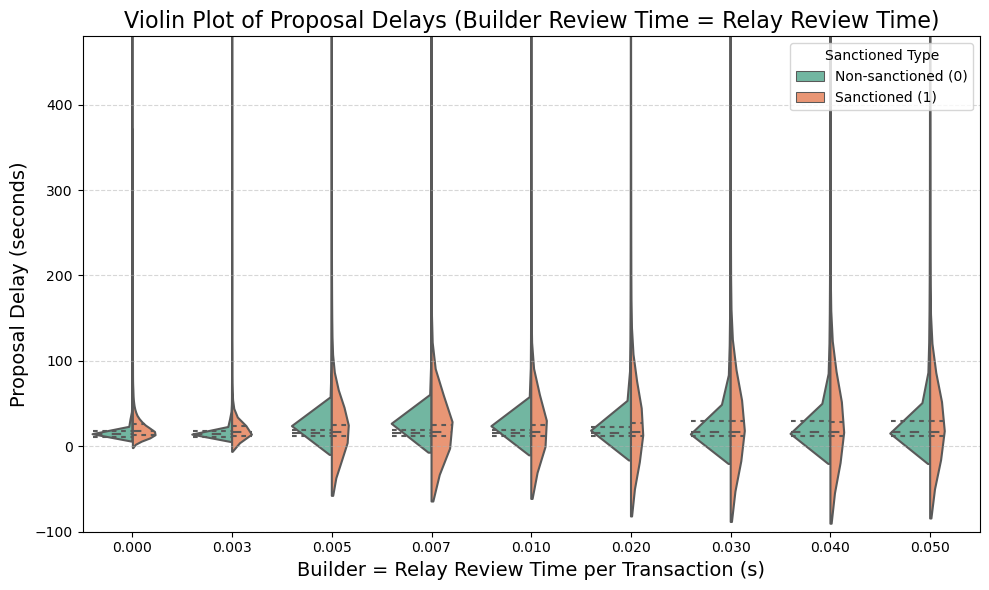

In [ ]:



selected_times = [0.000, 0.003, 0.005, 0.007, 0.010, 0.020, 0.030, 0.040, 0.050]

selected_data = combined_transactions[
    combined_transactions['builder_time'].isin(selected_times) &
    (combined_transactions['builder_time'] == combined_transactions['relay_time'])
].copy()


selected_data['time_label'] = selected_data['builder_time'].apply(lambda x: f"{x:.3f}")

plt.figure(figsize=(10, 6))

sns.violinplot(
    data=selected_data,
    x='time_label',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)

plt.ylim(-100, 480)
plt.xlabel('Builder = Relay Review Time per Transaction (s)', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays (Builder Review Time = Relay Review Time)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
####   -  builder_review_time_per_tx & relay_review_time_per_tx

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_review_time_per_tx_20250609_104129"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_review_time_per_tx_")]


def extract_builder_relay_times(folder_name):
    match = re.search(r"builder_relay_review_time_per_tx_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_time = float(match.group(1))
        relay_time = float(match.group(2))
        return (builder_time, relay_time)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_times)


results = []

for folder in folders:
    builder_time, relay_time = extract_builder_relay_times(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

   
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

       
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

   
    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'builder_time': builder_time,
        'relay_time': relay_time,
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: brt_{builder_time:.3f}_rrt_{relay_time:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")


Experiment: brt_0.000_rrt_0.000
平均含 sanctioned_type=1 交易的区块数量: 128.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 171.400000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 42.83%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 57.17%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: brt_0.000_rrt_0.003
平均含 sanctioned_type=1 交易的区块数量: 128.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 171.400000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 42.83%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 57.17%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: brt_0.000_rrt_0.005
平均含 sanctioned_type=1 交易的区块数量: 134.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 165.500000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 44.82%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 55.18%
平均空区块数量: 0.100000
空区块占所有已提议区块的比例: 0.03%

Experiment: brt_0.000_rrt_0.007
平均含 sanctioned_type=1 交易的区块数量: 134.100000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 165.800000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 44.72%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 55.28%


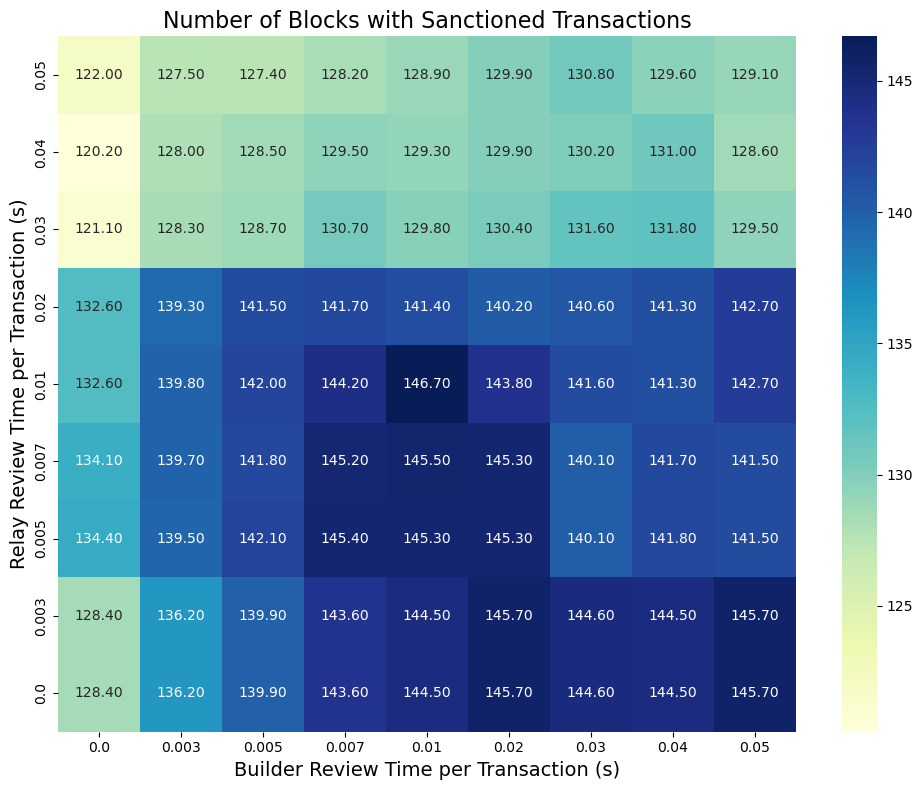

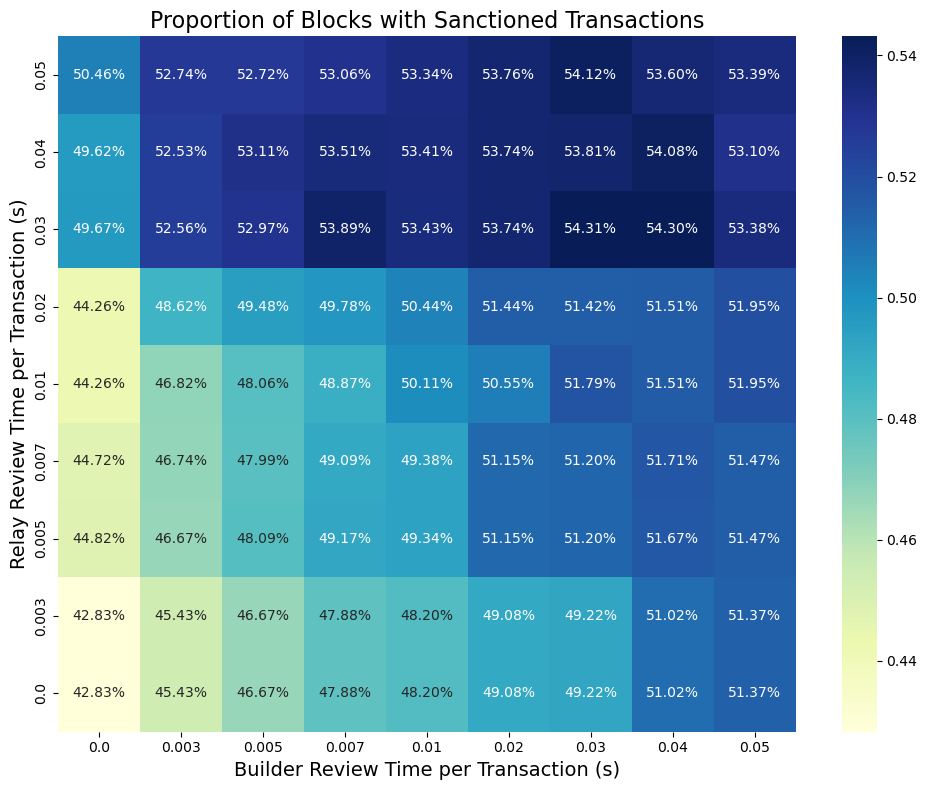

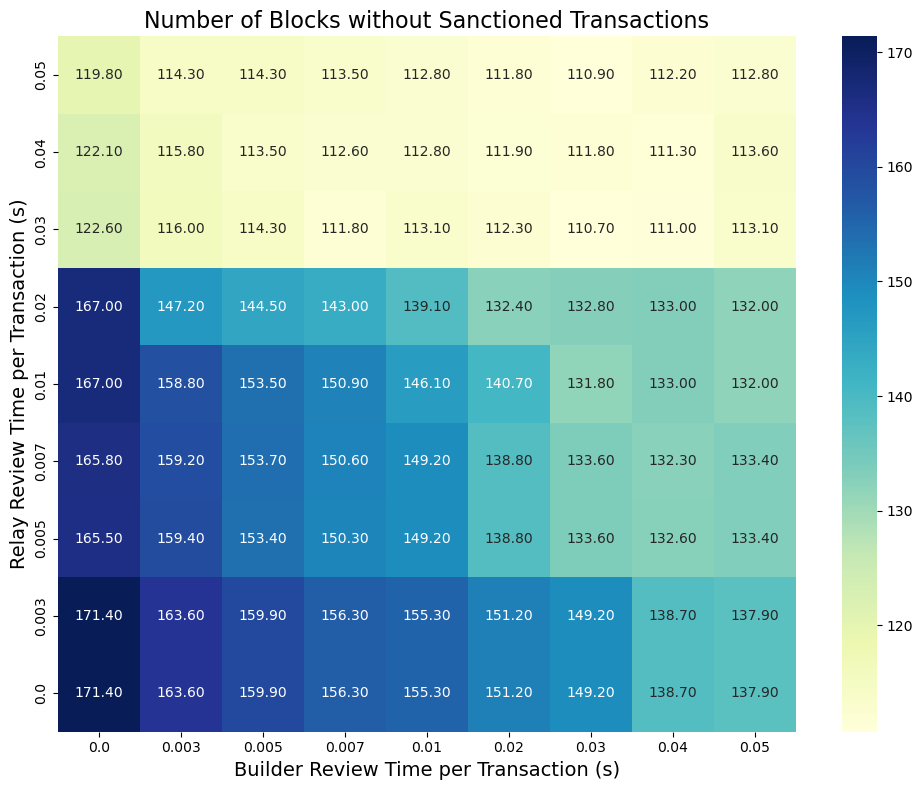

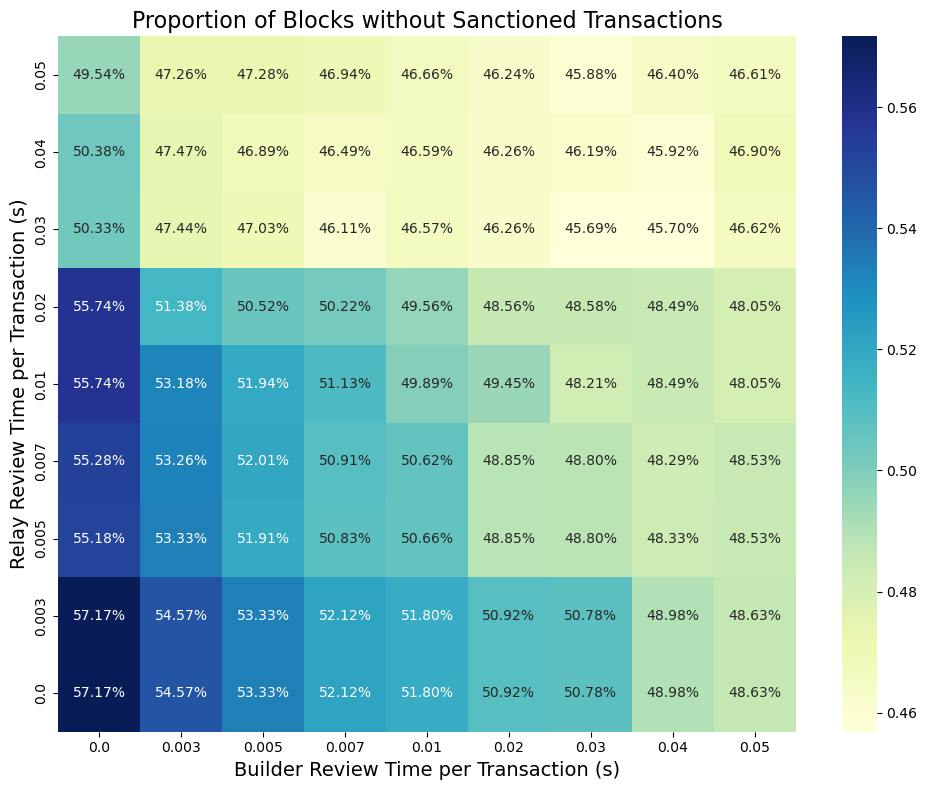

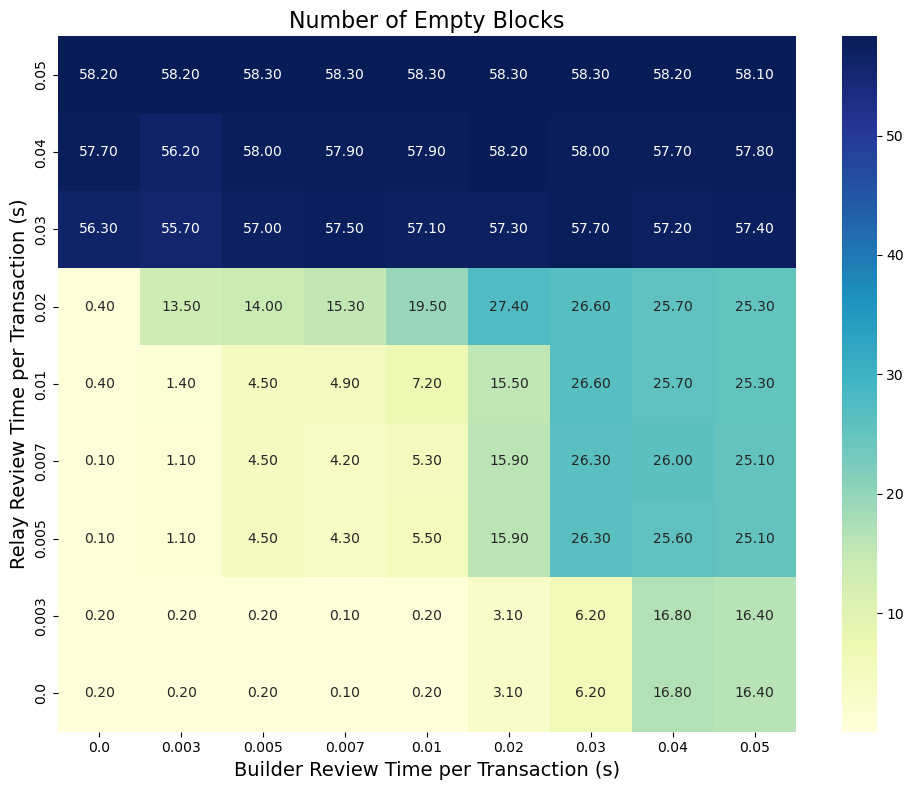

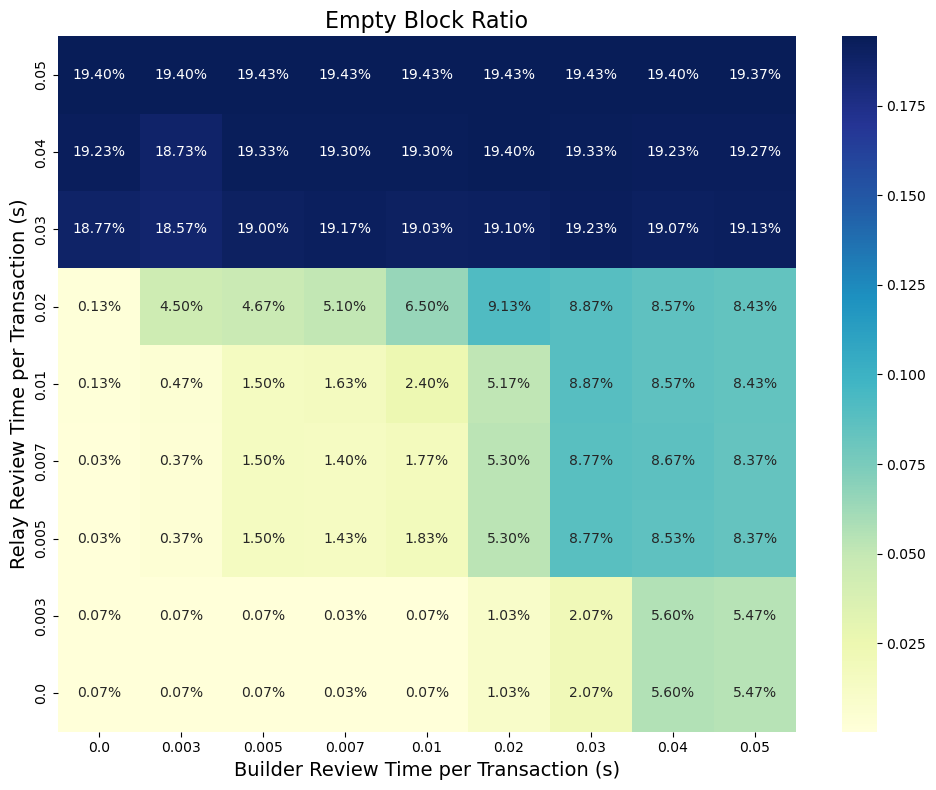

In [ ]:

results_df = pd.DataFrame(results)


def plot_heatmap(data, title, fmt):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(data, annot=True, fmt=fmt, cmap="YlGnBu")
    ax.invert_yaxis()  
    plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
    plt.ylabel('Relay Review Time per Transaction (s)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Figure 1: Heatmap of average blocks with sanctioned transactions
heatmap_data_1 = results_df.pivot(index='relay_time', columns='builder_time', values='avg_blocks_with_sanctioned')
plot_heatmap(heatmap_data_1, 'Number of Blocks with Sanctioned Transactions', ".2f")

# Figure 2: Heatmap of proportion of blocks with sanctioned transactions
heatmap_data_2 = results_df.pivot(index='relay_time', columns='builder_time', values='ratio_with_sanctioned')
plot_heatmap(heatmap_data_2, 'Proportion of Blocks with Sanctioned Transactions', ".2%")

# Figure 3: Heatmap of average blocks without sanctioned transactions
heatmap_data_5 = results_df.pivot(index='relay_time', columns='builder_time', values='avg_blocks_without_sanctioned')
plot_heatmap(heatmap_data_5, 'Number of Blocks without Sanctioned Transactions', ".2f")

# Figure 4: Heatmap of proportion of blocks without sanctioned transactions
heatmap_data_6 = results_df.pivot(index='relay_time', columns='builder_time', values='ratio_without_sanctioned')
plot_heatmap(heatmap_data_6, 'Proportion of Blocks without Sanctioned Transactions', ".2%")

# Figure 5: Empty blocks heatmap
heatmap_data_3 = results_df.pivot(index='relay_time', columns='builder_time', values='avg_empty_blocks')
plot_heatmap(heatmap_data_3, 'Number of Empty Blocks', ".2f")

# Figure 6: Empty block ratio heatmap
heatmap_data_4 = results_df.pivot(index='relay_time', columns='builder_time', values='empty_block_ratio')
plot_heatmap(heatmap_data_4, 'Empty Block Ratio', ".2%")



#### Total block value and mean block value   -  builder_review_time_per_tx & relay_review_time_per_tx

In [ ]:


def calculate_block_value_stats(exp_blocks, builder_time, relay_time):
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'builder_time': builder_time,
        'relay_time': relay_time,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }

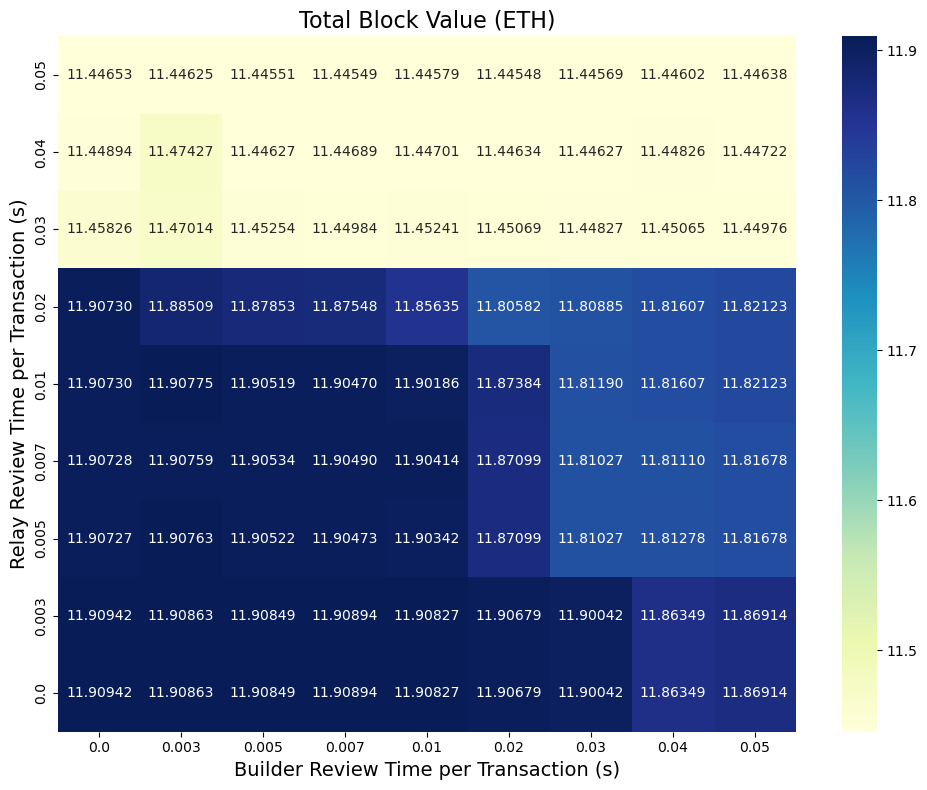

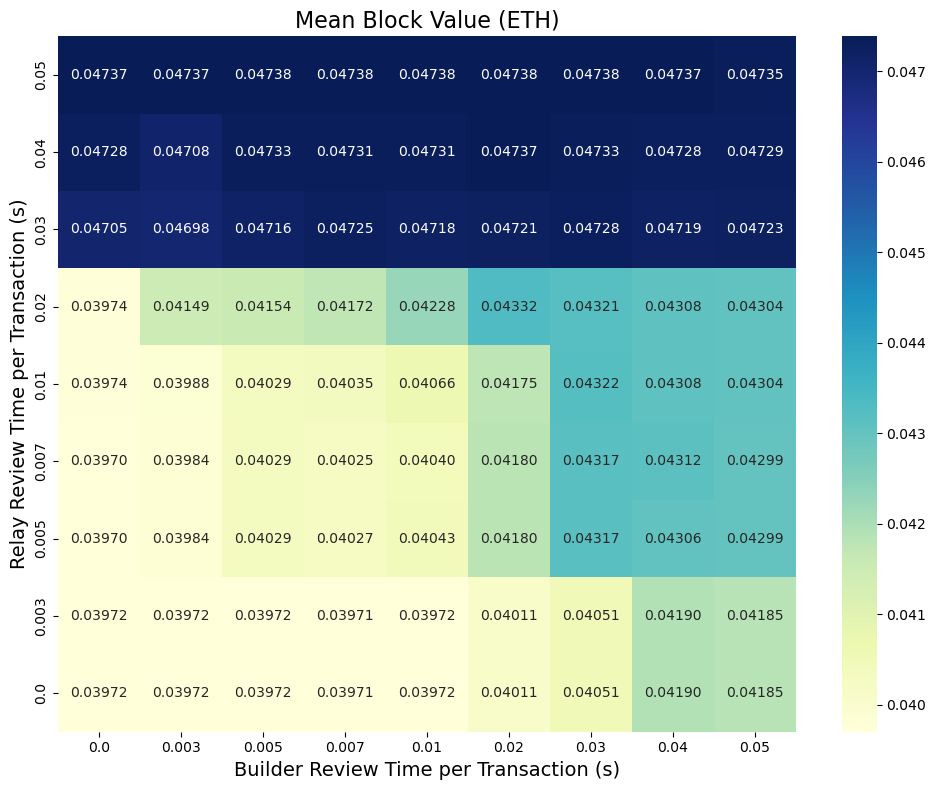

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_review_time_per_tx_20250609_104129"


def extract_builder_relay_times(folder_name):
    match = re.search(r"builder_relay_review_time_per_tx_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        return float(match.group(1)), float(match.group(2))
    return float('inf'), float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_review_time_per_tx_")]
folders.sort(key=extract_builder_relay_times)

results = []


for folder in folders:
    builder_time, relay_time = extract_builder_relay_times(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

 
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    stats = calculate_block_value_stats(blocks, builder_time, relay_time)
    results.append(stats)

combined_stats = pd.DataFrame(results)


def plot_heatmap(df, value_col, title, fmt=".5f"):
    pivot_df = df.pivot(index='relay_time', columns='builder_time', values=value_col)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
    plt.ylabel('Relay Review Time per Transaction (s)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_heatmap(
    combined_stats,
    'avg_total_block_value_eth',
    'Total Block Value (ETH)'
)


plot_heatmap(
    combined_stats,
    'avg_mean_block_value_eth',
    'Mean Block Value (ETH)'
)


#### Average profit (per block & pre node) for builders under different censorship types - builder_review_time_per_tx & relay_review_time_per_tx

In [ ]:

def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
    
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

    
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

    
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


    builder_policy  mean_builder_profit_per_block(ETH)  \
0              non                            0.001993   
1           strict                            0.001972   
2             weak                            0.001988   
3              non                            0.001993   
4           strict                            0.001972   
5             weak                            0.001988   
6              non                            0.002073   
7           strict                            0.001787   
8             weak                            0.001998   
9              non                            0.002068   
10          strict                            0.001793   
11            weak                            0.002003   
12             non                            0.002071   
13          strict                            0.001798   
14            weak                            0.002006   
15             non                            0.002071   
16          st

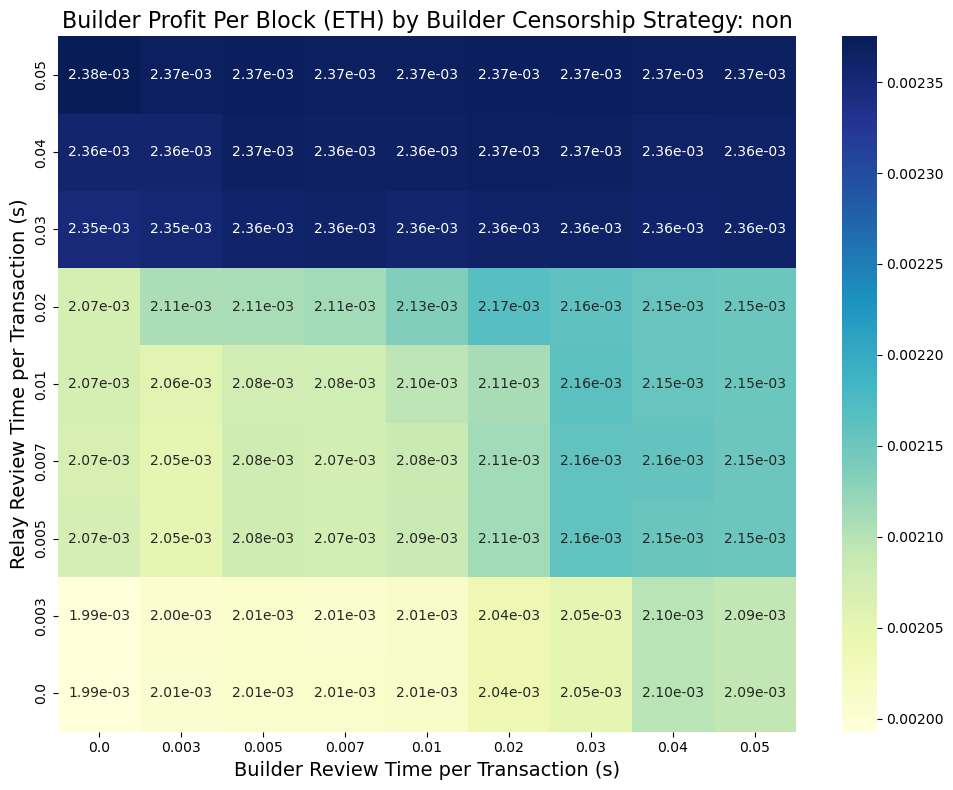

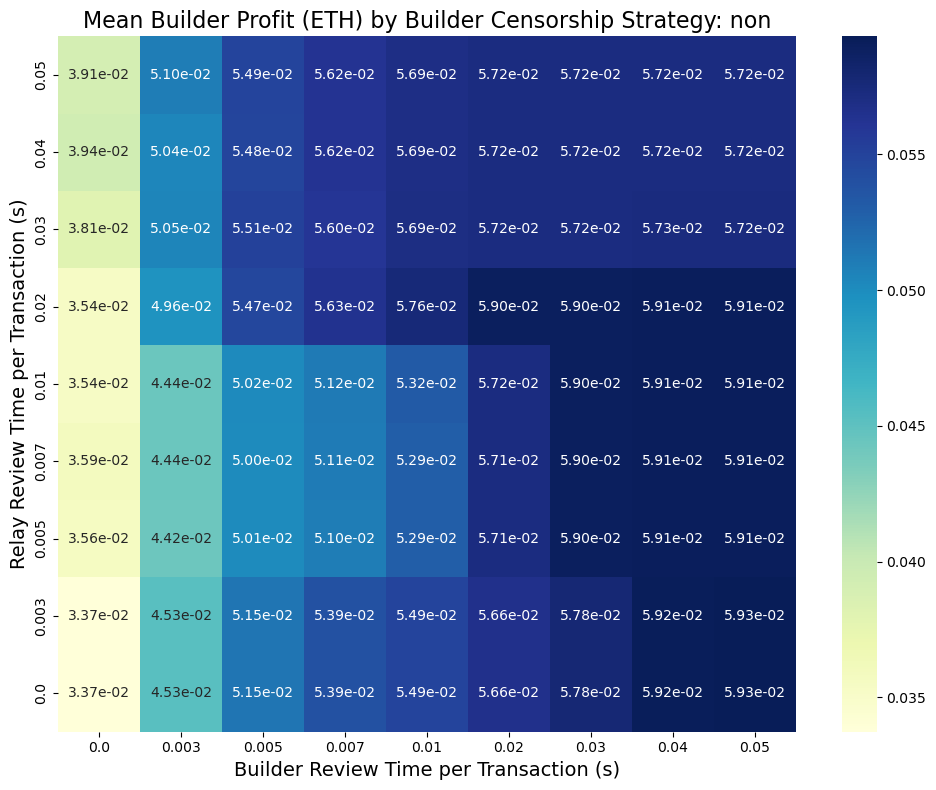

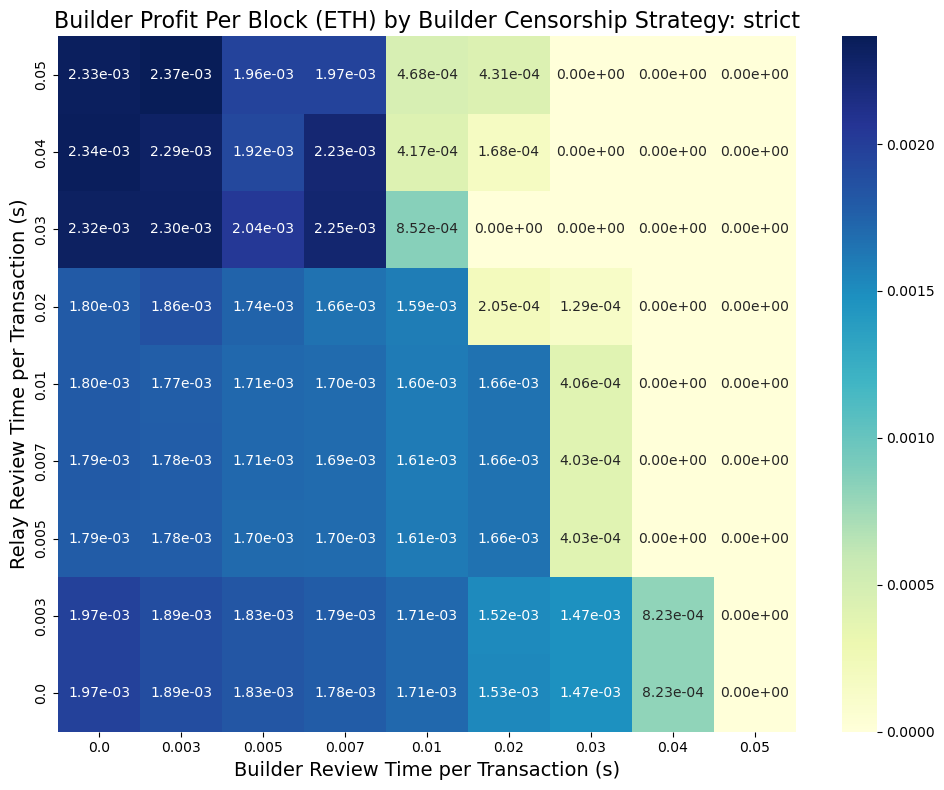

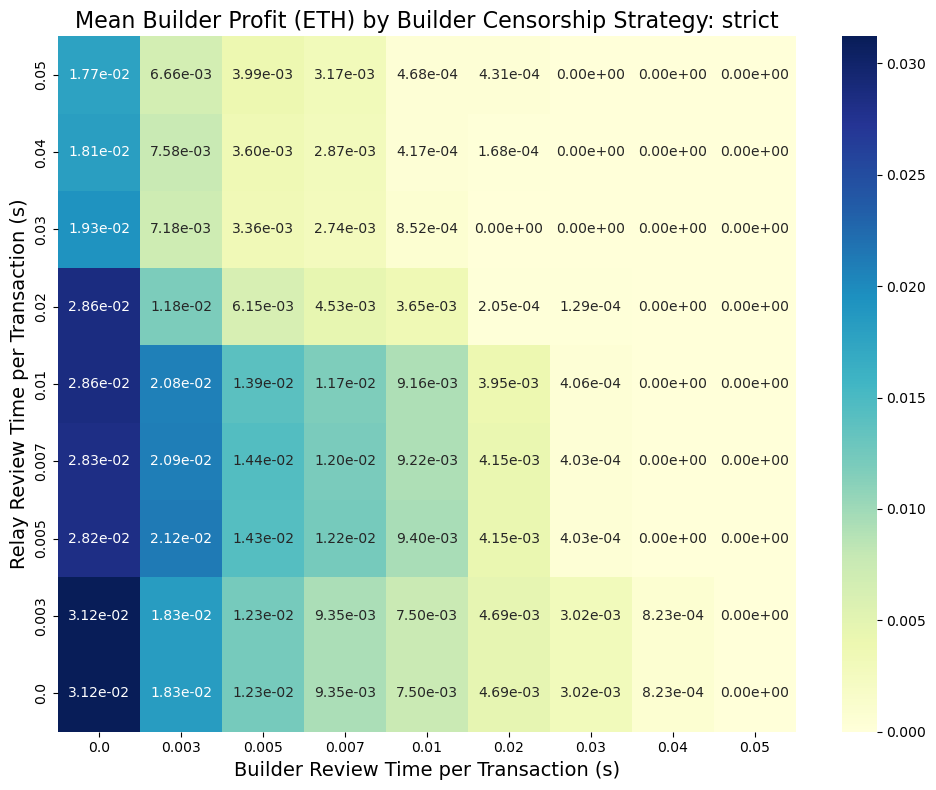

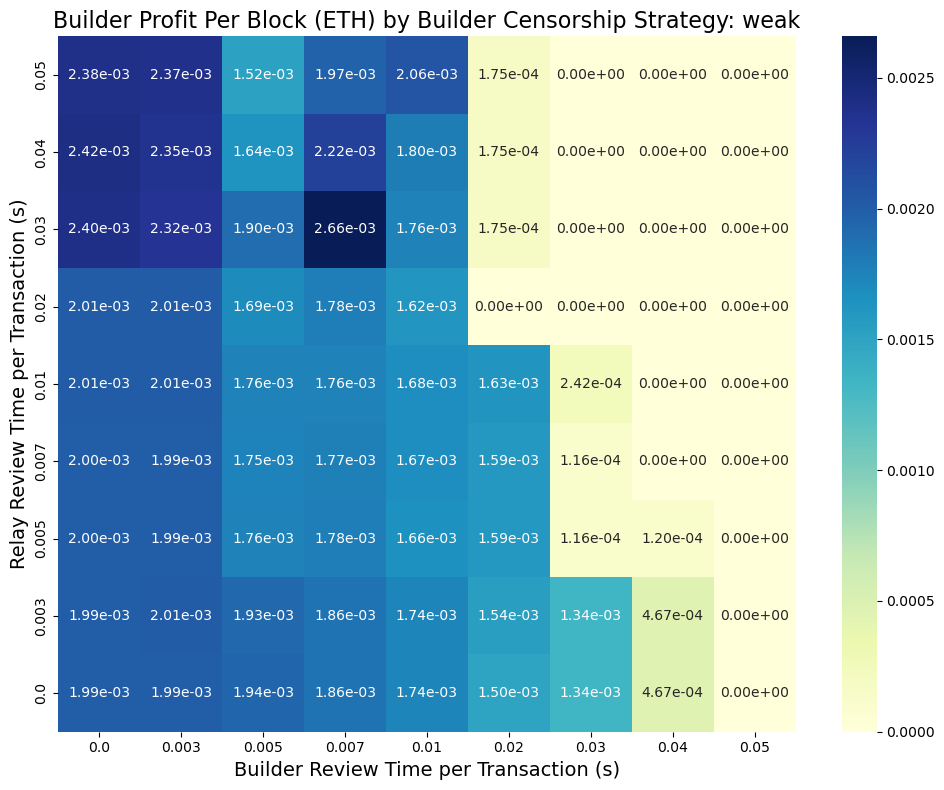

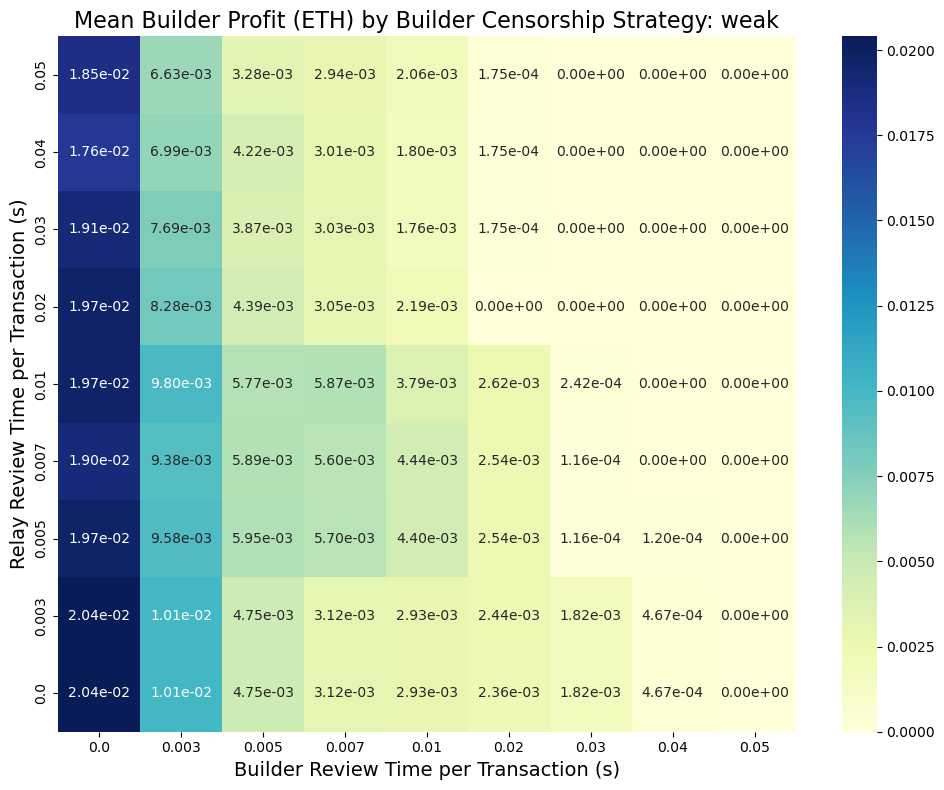

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_review_time_per_tx_20250609_104129"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_review_time_per_tx_")]


def extract_builder_relay_times(folder_name):
    match = re.search(r"builder_relay_review_time_per_tx_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_time = float(match.group(1))
        relay_time = float(match.group(2))
        return (builder_time, relay_time)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_times)

results = []


for folder in folders:
    builder_time, relay_time = extract_builder_relay_times(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

   
    experiment_label = f'brt_{builder_time:.3f}_rrt_{relay_time:.3f}'
    stats = calculate_builder_profit_by_policy(blocks, experiment_label)
    stats['builder_time'] = builder_time
    stats['relay_time'] = relay_time
    results.append(stats)


combined_stats = pd.concat(results, ignore_index=True)


print(combined_stats.sort_values(['builder_time', 'relay_time', 'builder_policy']))



def plot_heatmap(df, policy, value_col, title, fmt=".2e"):
    pivot_df = df[df['builder_policy'] == policy].pivot(
        index='relay_time', columns='builder_time', values=value_col)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
    plt.ylabel('Relay Review Time per Transaction (s)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()


policies = combined_stats['builder_policy'].unique()

for policy in policies:
    
    plot_heatmap(
        combined_stats, policy, 'mean_builder_profit_per_block(ETH)',
        f'Builder Profit Per Block (ETH) by Builder Censorship Strategy: {policy}'
    )

    
    plot_heatmap(
        combined_stats, policy, 'mean_builder_profit_per_builder(ETH)',
        f'Mean Builder Profit (ETH) by Builder Censorship Strategy: {policy}'
    )


#### Average profit (per block & pre node) for validators under different censorship types - builder_review_time_per_tx & relay_review_time_per_tx

In [54]:
def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]

     proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                              False                              0.037845   
1                               True                              0.037293   
2                              False                              0.037845   
3                               True                              0.037293   
4                              False                              0.039786   
5                               True                              0.029136   
6                              False                              0.039786   
7                               True                              0.029138   
8                              False                              0.039798   
9                               True                              0.029244   
10                             False                              0.039798   
11                              True                            

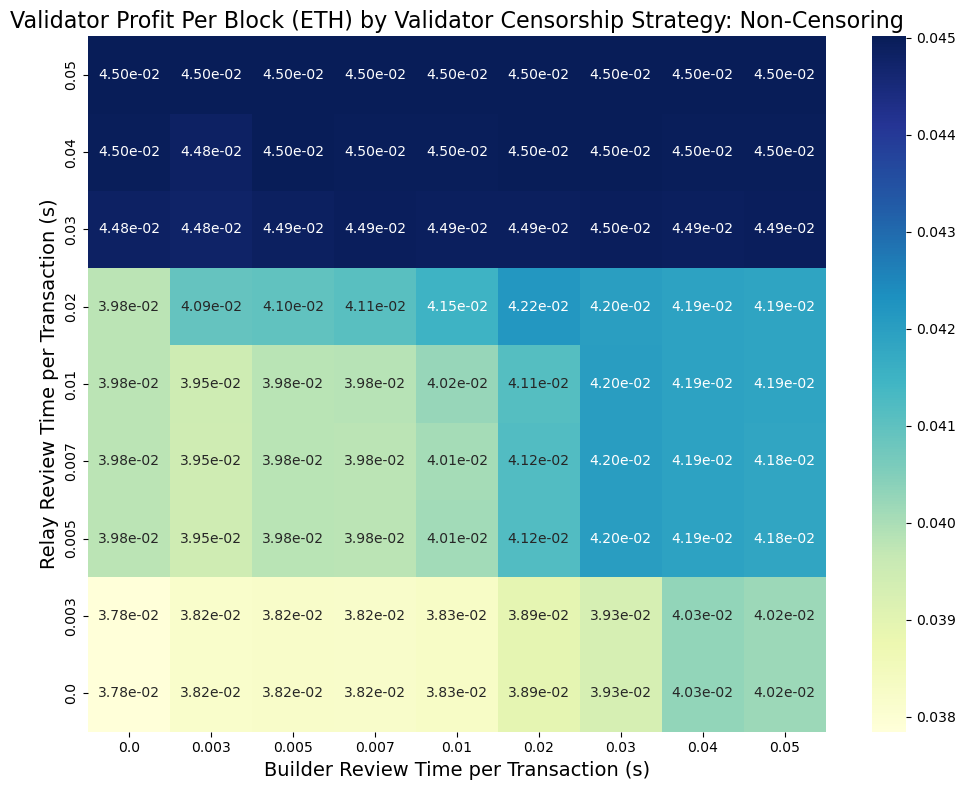

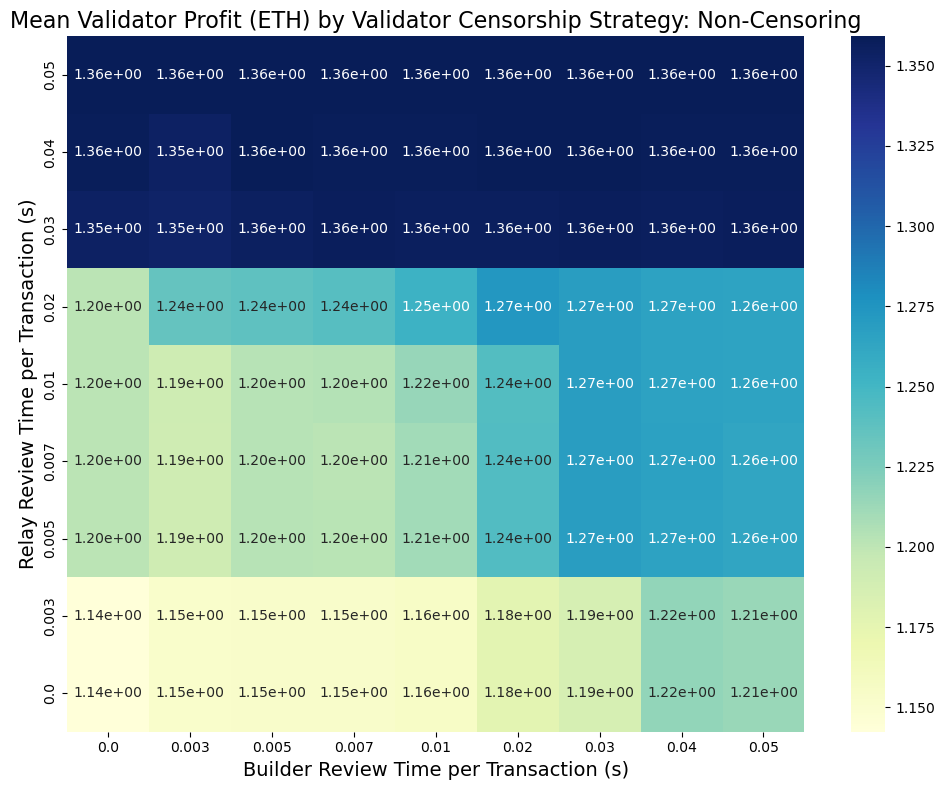

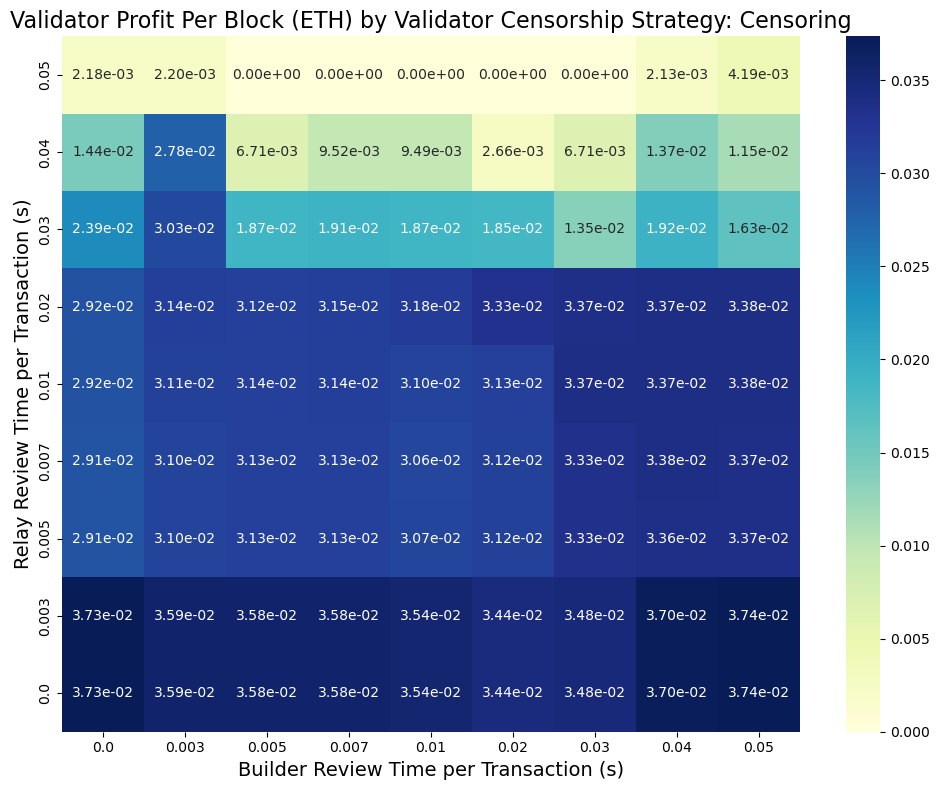

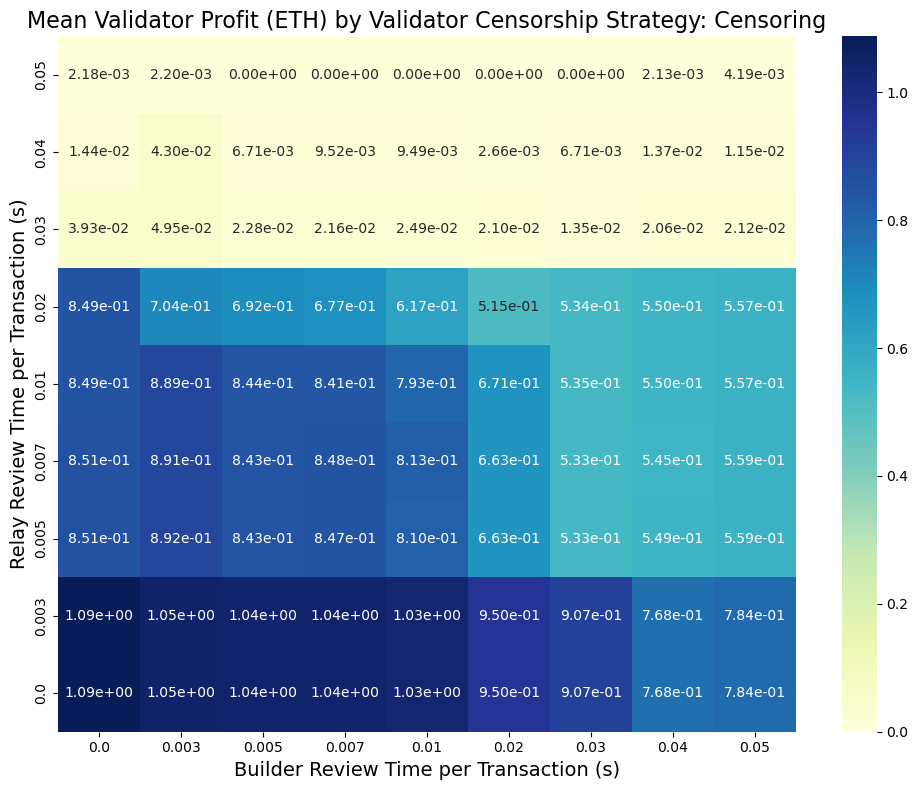

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_review_time_per_tx_20250609_104129"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_review_time_per_tx_")]


def extract_builder_relay_times(folder_name):
    match = re.search(r"builder_relay_review_time_per_tx_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_time = float(match.group(1))
        relay_time = float(match.group(2))
        return (builder_time, relay_time)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_times)

results = []


for folder in folders:
    builder_time, relay_time = extract_builder_relay_times(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    experiment_label = f'brt_{builder_time:.3f}_rrt_{relay_time:.3f}'
    stats = calculate_validator_profit_by_policy(blocks, experiment_label)
    stats['builder_time'] = builder_time
    stats['relay_time'] = relay_time
    results.append(stats)


combined_stats = pd.concat(results, ignore_index=True)


print(combined_stats.sort_values(['builder_time', 'relay_time', 'proposer_validator_is_censoring']))



def plot_validator_heatmap(df, is_censoring, value_col, title, fmt=".2e"):
    pivot_df = df[df['proposer_validator_is_censoring'] == is_censoring].pivot(
        index='relay_time', columns='builder_time', values=value_col)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel('Builder Review Time per Transaction (s)', fontsize=14)
    plt.ylabel('Relay Review Time per Transaction (s)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()


policies = combined_stats['proposer_validator_is_censoring'].unique()

for policy in policies:
    policy_label = 'Censoring' if policy else 'Non-Censoring'

   
    plot_validator_heatmap(
        combined_stats, policy, 'mean_validator_profit_per_block(ETH)',
        f'Validator Profit Per Block (ETH) by Validator Censorship Strategy: {policy_label}'
    )

    
    plot_validator_heatmap(
        combined_stats, policy, 'mean_validator_profit_per_validator(ETH)',
        f'Mean Validator Profit (ETH) by Validator Censorship Strategy: {policy_label}'
    )
